Quantum RNG available: True

GENERATING TERRAIN WITH REALISTIC LAYERS

Configuration:
  Grid: 256×256, Pixel: 20.0m, Elevation: 500.0m
  Weather: 100 years, Wind: 90.0° (EAST)

Generating terrain...
✓ Terrain generated in 0.1 s
  Elevation: 0.0 - 500.0 m
  Layers: ['Topsoil', 'Subsoil', 'Colluvium', 'Saprolite', 'WeatheredBR', 'Basement']

  Layer thickness summary:
    Topsoil        : 0.40 - 2.80 m (mean: 0.78 m)
    Subsoil        : 2.50 - 6.50 m (mean: 4.03 m)
    Colluvium      : 0.00 - 15.00 m (mean: 4.83 m)
    Saprolite      : 0.50 - 24.99 m (mean: 3.89 m)
    WeatheredBR    : 1.50 - 9.00 m (mean: 4.36 m)
    Basement       : 1000.00 - 1000.00 m (mean: 1000.00 m)

Generating 100 years of weather...
  Wind direction: 90.0° (EAST → to the right)
  Wind barriers: 28449 cells
  Wind channels: 37087 cells
  Year 20/100: 1.000 m/yr (range: 0.000 - 32.072)
  Year 40/100: 1.000 m/yr (range: 0.000 - 14.761)
  Year 60/100: 1.000 m/yr (range: 0.000 - 31.174)
  Year 80/100: 1.000 m/yr (ran

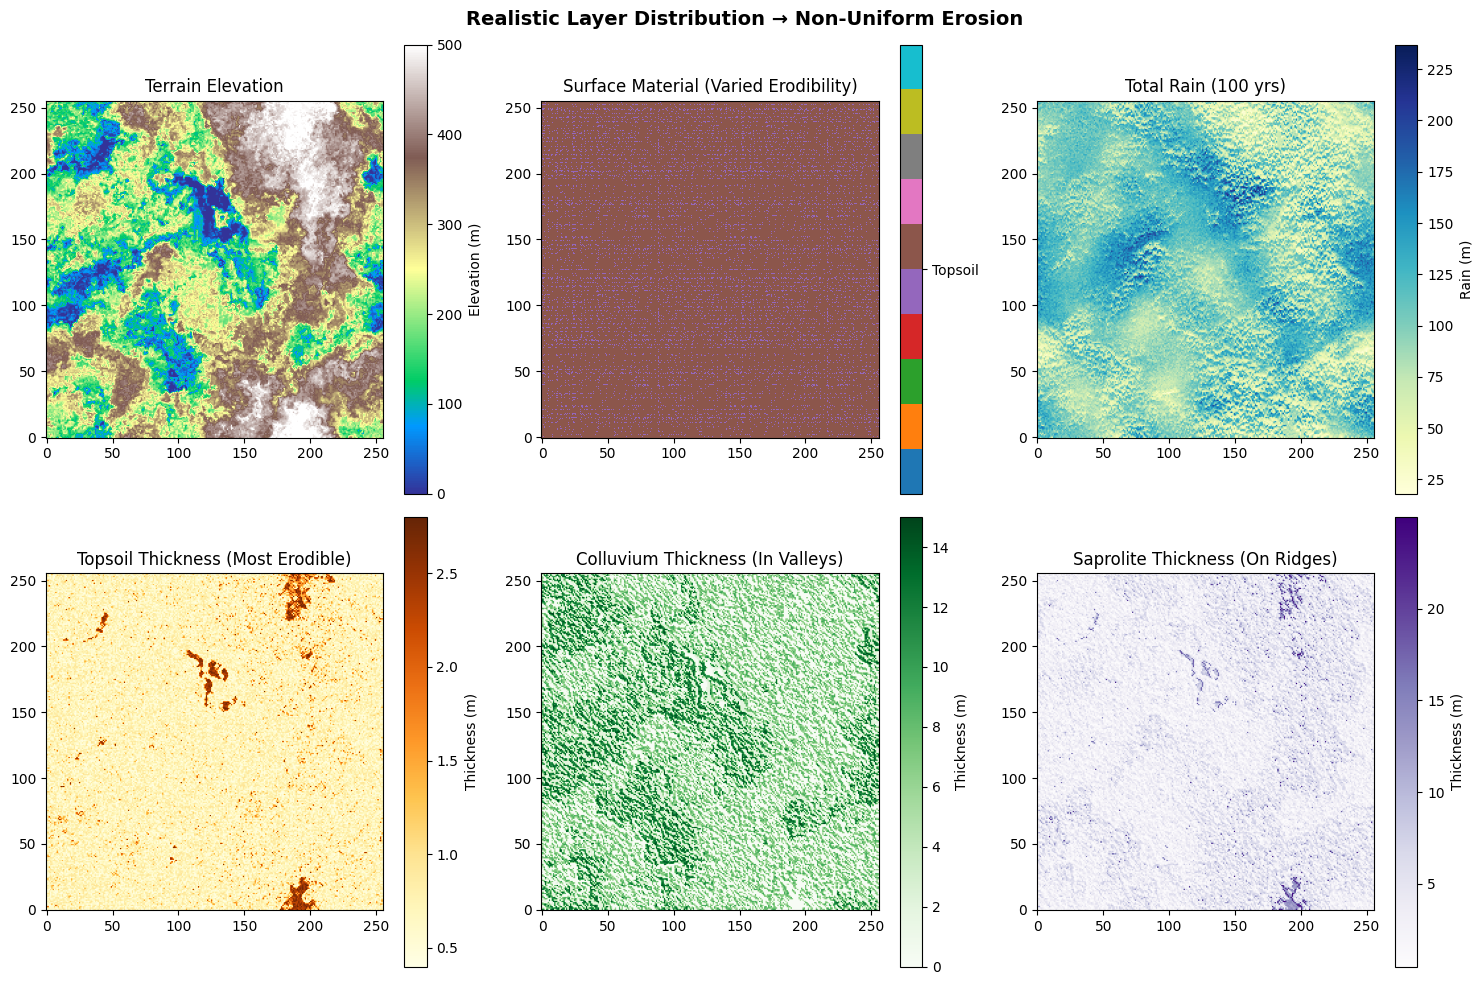

✓ Visualization complete - Notice varied surface materials!


In [17]:
"""
COMPLETE TERRAIN + WEATHER SYSTEM WITH REALISTIC LAYERS

Features:
- Wind: EAST (90°) with proper barrier/channel physics
- Layers: Topsoil, Subsoil, Colluvium, Saprolite, Weathered Bedrock, Basement
- Different erodibility for each layer → non-uniform erosion
- Quantum random rain within storms
- Single terrain map for erosion simulator
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, List
import time

# ==============================================================================
# QUANTUM RNG
# ==============================================================================

try:
    import qiskit
    try:
        import qiskit_aer
        HAVE_QISKIT = True
    except Exception:
        HAVE_QISKIT = False
except Exception:
    HAVE_QISKIT = False

print(f"Quantum RNG available: {HAVE_QISKIT}")


def qrng_uint32(n, nbits=32):
    if not HAVE_QISKIT:
        return np.random.default_rng().integers(0, 2**32, size=n, dtype=np.uint32)
    
    from qiskit import QuantumCircuit
    try:
        from qiskit_aer import Aer
    except Exception:
        try:
            from qiskit import Aer
        except Exception:
            return np.random.default_rng().integers(0, 2**32, size=n, dtype=np.uint32)
    
    qc = QuantumCircuit(nbits, nbits)
    qc.h(range(nbits))
    qc.measure(range(nbits), range(nbits))
    backend = Aer.get_backend("qasm_simulator")
    
    import os
    seed_sim = int.from_bytes(os.urandom(4), "little")
    job = backend.run(qc, shots=n, memory=True, seed_simulator=seed_sim)
    mem = job.result().get_memory(qc)
    
    return np.array([np.uint32(int(bits[::-1], 2)) for bits in mem], dtype=np.uint32)


def rng_from_qrng(n_seeds=4, random_seed=None):
    if random_seed is not None:
        return np.random.default_rng(int(random_seed))
    
    import os, time, hashlib
    seeds = qrng_uint32(n_seeds).tobytes()
    mix = seeds + os.urandom(16) + int(time.time_ns()).to_bytes(8, "little")
    h = hashlib.blake2b(mix, digest_size=8).digest()
    return np.random.default_rng(int.from_bytes(h, "little"))


def quantum_uniforms(n, backend=None, seed_sim=None):
    if not HAVE_QISKIT:
        return np.random.default_rng().uniform(0, 1, size=n)
    
    nbits = 16
    bits = qrng_uint32(n, nbits=nbits)
    return bits.astype(np.float64) / (2.0**nbits)


# ==============================================================================
# TERRAIN GENERATION
# ==============================================================================

def fractional_surface(N, beta=3.0, rng=None):
    rng = rng or np.random.default_rng()
    kx = np.fft.fftfreq(N)
    ky = np.fft.rfftfreq(N)
    K = np.sqrt(kx[:, None]**2 + ky[None, :]**2)
    K[0, 0] = np.inf
    amp = 1.0 / (K ** (beta/2))
    phase = rng.uniform(0, 2*np.pi, size=(N, ky.size))
    spec = amp * (np.cos(phase) + 1j*np.sin(phase))
    spec[0, 0] = 0.0
    z = np.fft.irfftn(spec, s=(N, N), axes=(0, 1))
    lo, hi = np.percentile(z, [2, 98])
    return np.clip((z - lo)/(hi - lo + 1e-12), 0, 1)


def bilinear_sample(img, X, Y):
    N = img.shape[0]
    x0 = np.floor(X).astype(int) % N
    y0 = np.floor(Y).astype(int) % N
    x1 = (x0+1) % N
    y1 = (y0+1) % N
    dx = X - np.floor(X)
    dy = Y - np.floor(Y)
    return ((1-dx)*(1-dy)*img[x0,y0] + dx*(1-dy)*img[x1,y0] +
            (1-dx)*dy*img[x0,y1] + dx*dy*img[x1,y1])


def domain_warp(z, rng, amp=0.10, beta=3.0):
    N = z.shape[0]
    u = fractional_surface(N, beta=beta, rng=rng)*2 - 1
    v = fractional_surface(N, beta=beta, rng=rng)*2 - 1
    ii, jj = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
    Xw = (ii + amp*N*u) % N
    Yw = (jj + amp*N*v) % N
    return bilinear_sample(z, Xw, Yw)


def ridged_mix(z, alpha=0.15):
    ridged = 1.0 - np.abs(2.0*z - 1.0)
    out = (1-alpha)*z + alpha*ridged
    lo, hi = np.percentile(out, [2, 98])
    return np.clip((out - lo)/(hi - lo + 1e-12), 0, 1)


def quantum_seeded_topography(N=256, beta=3.0, warp_amp=0.10, 
                               ridged_alpha=0.15, random_seed=None):
    rng = rng_from_qrng(n_seeds=4, random_seed=random_seed)
    
    base_low = fractional_surface(N, beta=beta, rng=rng)
    base_high = fractional_surface(N, beta=beta-0.4, rng=rng)
    z = 0.65*base_low + 0.35*base_high
    
    z = domain_warp(z, rng=rng, amp=warp_amp, beta=beta)
    z = ridged_mix(z, alpha=ridged_alpha)
    
    return z, rng


# ==============================================================================
# REALISTIC LAYER GENERATION (From original Project.ipynb)
# ==============================================================================

def generate_stratigraphy_with_layers(z_norm, rng, pixel_scale_m=20.0, elev_range_m=500.0):
    """
    Generate realistic stratigraphy with varied surface materials.
    
    Layers (top to bottom):
    1. Topsoil - thin, erodible, on gentle slopes
    2. Subsoil - thicker, moderately erodible
    3. Colluvium - gravity-deposited, in valleys
    4. Saprolite - weathered bedrock, on interfluves
    5. Weathered Bedrock - partially weathered, resistant
    6. Basement - unweathered, very resistant
    
    Each layer has different thickness based on:
    - Elevation
    - Slope
    - Topographic position
    """
    ny, nx = z_norm.shape
    surface_elev = z_norm * elev_range_m
    
    # Define layer order
    layer_order = ['Topsoil', 'Subsoil', 'Colluvium', 'Saprolite', 'WeatheredBR', 'Basement']
    
    thickness = {}
    
    # Compute slope
    grad_y, grad_x = np.gradient(z_norm, pixel_scale_m / elev_range_m)
    slope_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Compute curvature (for detecting valleys vs ridges)
    grad2_y, grad2_x = np.gradient(slope_mag)
    curvature = grad2_y + grad2_x  # Negative = valleys, Positive = ridges
    
    # ==== LAYER 1: TOPSOIL ====
    # Thicker on gentle slopes, thinner on steep slopes
    gentle_mask = slope_mag < 0.1
    steep_mask = slope_mag > 0.3
    
    topsoil = np.ones((ny, nx)) * 1.5  # Base thickness
    topsoil[gentle_mask] += 1.0  # Extra on gentle slopes
    topsoil[steep_mask] -= 0.8  # Thin on steep slopes
    topsoil += rng.uniform(-0.3, 0.3, size=(ny, nx))  # Variability
    thickness['Topsoil'] = np.maximum(0.2, topsoil)
    
    # ==== LAYER 2: SUBSOIL ====
    # Thicker in mid-elevation areas
    mid_elev_mask = (z_norm > 0.3) & (z_norm < 0.7)
    
    subsoil = np.ones((ny, nx)) * 3.0
    subsoil[mid_elev_mask] += 2.0
    subsoil[gentle_mask] += 1.0
    subsoil += rng.uniform(-0.5, 0.5, size=(ny, nx))
    thickness['Subsoil'] = np.maximum(0.5, subsoil)
    
    # ==== LAYER 3: COLLUVIUM ====
    # Gravity-driven deposits in valleys and at slope bases
    # Thick where curvature is negative (concave = valleys)
    valley_mask = curvature < -0.0001
    low_elev_mask = z_norm < 0.4
    
    colluvium = np.zeros((ny, nx))
    colluvium[valley_mask] = 5.0 + rng.uniform(0, 5, size=np.sum(valley_mask))
    colluvium[valley_mask & low_elev_mask] += 3.0  # Extra thick in low valleys
    colluvium[steep_mask & low_elev_mask] += 2.0  # Accumulated at slope base
    thickness['Colluvium'] = np.maximum(0.0, colluvium)
    
    # ==== LAYER 4: SAPROLITE ====
    # Weathered bedrock, thick on stable interfluves (ridges)
    # Minimal in valleys where it's been stripped
    ridge_mask = curvature > 0.0001
    high_elev_mask = z_norm > 0.5
    
    saprolite = np.ones((ny, nx)) * 8.0
    saprolite[ridge_mask & gentle_mask] += 10.0  # Thick on stable ridges
    saprolite[high_elev_mask] += 5.0  # Thicker at high elevation
    saprolite[valley_mask] *= 0.3  # Thin in valleys (stripped)
    saprolite[steep_mask] *= 0.5  # Thinner on steep slopes
    saprolite += rng.uniform(-2, 2, size=(ny, nx))
    thickness['Saprolite'] = np.maximum(0.5, saprolite)
    
    # ==== LAYER 5: WEATHERED BEDROCK ====
    # Partially weathered, patchy distribution
    # Use fractal pattern for realistic patchiness
    patch_pattern = fractional_surface(ny, beta=3.0, rng=rng)
    
    weathered_br = 3.0 + 4.0 * patch_pattern
    weathered_br[high_elev_mask] += 2.0  # Thicker at high elevation
    weathered_br[valley_mask] *= 0.5  # Thinner in valleys
    thickness['WeatheredBR'] = np.maximum(0.5, weathered_br)
    
    # ==== LAYER 6: BASEMENT ====
    # Unweathered bedrock, infinite thickness
    thickness['Basement'] = np.ones((ny, nx)) * 1000.0
    
    return {
        'surface_elev': surface_elev,
        'thickness': thickness,
        'layer_order': layer_order,
        'pixel_scale_m': pixel_scale_m,
        'slope_mag': slope_mag,
        'curvature': curvature
    }


def compute_top_layer_map(thickness: Dict[str, np.ndarray], 
                          layer_order: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    """Determine which layer is exposed at surface."""
    N, M = next(iter(thickness.values())).shape
    top_idx = -np.ones((N, M), dtype=int)
    top_name = np.empty((N, M), dtype=object)
    
    for k, layer in enumerate(layer_order):
        th = thickness[layer]
        mask = (th > 1e-3) & (top_idx == -1)
        top_idx[mask] = k
        top_name[mask] = layer
    
    top_name[top_idx == -1] = "Basement"
    return top_idx, top_name


# ==============================================================================
# WIND-TOPOGRAPHY INTERACTION (Same as before)
# ==============================================================================

def classify_wind_features(surface_elev, pixel_scale_m, wind_dir_deg=90.0):
    """Classify terrain for wind interaction."""
    ny, nx = surface_elev.shape
    
    grad_y, grad_x = np.gradient(surface_elev, pixel_scale_m)
    
    wind_rad = np.radians(wind_dir_deg)
    wind_x = np.cos(wind_rad)
    wind_y = np.sin(wind_rad)
    wind_vector = (wind_x, wind_y)
    
    slope_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    grad2_y, grad2_x = np.gradient(slope_mag, pixel_scale_m)
    curvature = np.sqrt(grad2_x**2 + grad2_y**2)
    
    elev_norm = (surface_elev - surface_elev.min()) / (surface_elev.max() - surface_elev.min() + 1e-9)
    curv_norm = (curvature - curvature.min()) / (curvature.max() - curvature.min() + 1e-9)
    
    barrier_score = 0.5 * curv_norm + 0.5 * elev_norm
    barrier_score = barrier_score ** 2
    barrier_score = np.clip(barrier_score, 0, 1)
    
    channel_score = (1 - elev_norm) * (1 - curv_norm)
    channel_score = channel_score ** 2
    channel_score = np.clip(channel_score, 0, 1)
    
    total_score = barrier_score + channel_score + 1e-9
    barrier_score = barrier_score / total_score
    channel_score = channel_score / total_score
    
    return {
        'barrier_score': barrier_score.astype(np.float32),
        'channel_score': channel_score.astype(np.float32),
        'slope_vectors': (grad_x.astype(np.float32), grad_y.astype(np.float32)),
        'wind_vector': wind_vector,
        'wind_dir_deg': wind_dir_deg
    }


def apply_wind_rain_physics(base_rain, wind_features, k_windward=0.8, k_lee=0.6, k_channel=0.5):
    """Apply barrier and channel physics to rain."""
    ny, nx = base_rain.shape
    
    slope_x, slope_y = wind_features['slope_vectors']
    wind_x, wind_y = wind_features['wind_vector']
    barrier_score = wind_features['barrier_score']
    channel_score = wind_features['channel_score']
    
    slope_mag = np.sqrt(slope_x**2 + slope_y**2) + 1e-9
    cos_theta = (slope_x * wind_x + slope_y * wind_y) / slope_mag
    
    barrier_factor = np.ones((ny, nx), dtype=np.float32)
    
    windward_mask = cos_theta > 0
    barrier_factor[windward_mask] = 1.0 + k_windward * cos_theta[windward_mask] * barrier_score[windward_mask]
    
    leeward_mask = cos_theta < 0
    barrier_factor[leeward_mask] = 1.0 - k_lee * (-cos_theta[leeward_mask]) * barrier_score[leeward_mask]
    
    barrier_factor = np.clip(barrier_factor, 0.2, 2.5)
    
    channel_factor = 1.0 + k_channel * channel_score
    
    rain = base_rain * barrier_factor * channel_factor
    
    return rain


def generate_storm_with_quantum_rain(surface_elev, wind_features, storm_center_ij,
                                      storm_radius_cells, base_intensity_m_per_hour,
                                      duration_hours, pixel_scale_m, rng):
    """Generate storm with quantum random rain and wind physics."""
    ny, nx = surface_elev.shape
    ci, cj = storm_center_ij
    
    ii, jj = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')
    di = ii - ci
    dj = jj - cj
    
    di = np.where(di > ny/2, di - ny, di)
    di = np.where(di < -ny/2, di + ny, di)
    dj = np.where(dj > nx/2, dj - nx, dj)
    dj = np.where(dj < -nx/2, dj + nx, dj)
    
    dist = np.sqrt(di**2 + dj**2)
    base_storm = np.exp(-(dist / storm_radius_cells)**2)
    
    storm_cells = base_storm > 0.1
    n_storm_cells = np.sum(storm_cells)
    
    if n_storm_cells > 0:
        try:
            quantum_mults = quantum_uniforms(n_storm_cells)
            quantum_mults = np.exp((quantum_mults - 0.5) * 1.5)
        except:
            quantum_mults = np.exp((rng.uniform(0, 1, size=n_storm_cells) - 0.5) * 1.5)
        
        base_storm_quantum = base_storm.copy()
        base_storm_quantum[storm_cells] *= quantum_mults
        base_storm = base_storm_quantum
    
    base_rain = base_intensity_m_per_hour * duration_hours * base_storm
    rain = apply_wind_rain_physics(base_rain, wind_features, k_windward=0.8, k_lee=0.6, k_channel=0.5)
    
    return rain


def run_weather_simulation(surface_elev, pixel_scale_m, num_years=10, wind_dir_deg=90.0,
                           mean_annual_rain_m=1.0, random_seed=None):
    """Run multi-year weather simulation."""
    print(f"\nGenerating {num_years} years of weather...")
    print(f"  Wind direction: {wind_dir_deg}° (EAST → to the right)")
    
    ny, nx = surface_elev.shape
    rng = rng_from_qrng(random_seed=random_seed)
    
    wind_features = classify_wind_features(surface_elev, pixel_scale_m, wind_dir_deg)
    
    barrier_cells = np.sum(wind_features['barrier_score'] > 0.5)
    channel_cells = np.sum(wind_features['channel_score'] > 0.5)
    print(f"  Wind barriers: {barrier_cells} cells")
    print(f"  Wind channels: {channel_cells} cells")
    
    annual_rain_maps = []
    
    for year in range(num_years):
        year_rain = np.zeros((ny, nx), dtype=np.float32)
        
        n_storms = rng.integers(5, 16)
        
        for storm_idx in range(n_storms):
            ci = rng.integers(0, ny)
            cj = rng.integers(0, nx)
            radius = rng.integers(10, 30)
            intensity = rng.uniform(0.001, 0.005)
            duration = rng.uniform(4, 24)
            
            storm_rain = generate_storm_with_quantum_rain(
                surface_elev, wind_features,
                (ci, cj), radius, intensity, duration,
                pixel_scale_m, rng
            )
            
            year_rain += storm_rain
        
        scale_factor = mean_annual_rain_m / (year_rain.mean() + 1e-9)
        year_rain *= scale_factor
        
        annual_rain_maps.append(year_rain)
        
        if (year + 1) % max(1, num_years // 5) == 0:
            print(f"  Year {year+1}/{num_years}: {year_rain.mean():.3f} m/yr (range: {year_rain.min():.3f} - {year_rain.max():.3f})")
    
    total_rain = np.sum(annual_rain_maps, axis=0)
    
    print(f"✓ Weather simulation complete")
    print(f"  Total rainfall: {total_rain.mean():.2f} m over {num_years} years")
    
    return {
        'annual_rain_maps': annual_rain_maps,
        'wind_features': wind_features,
        'total_rain': total_rain,
        'num_years': num_years
    }


# ==============================================================================
# GENERATE INITIAL TERRAIN AND WEATHER
# ==============================================================================

print("\n" + "="*80)
print("GENERATING TERRAIN WITH REALISTIC LAYERS")
print("="*80)

N = 256
pixel_scale_m = 20.0
elev_range_m = 500.0
num_weather_years = 100
wind_dir_deg = 90.0
mean_annual_rain_m = 1.0

print(f"\nConfiguration:")
print(f"  Grid: {N}×{N}, Pixel: {pixel_scale_m}m, Elevation: {elev_range_m}m")
print(f"  Weather: {num_weather_years} years, Wind: {wind_dir_deg}° (EAST)")

print("\nGenerating terrain...")
start_time = time.time()

z_norm, rng = quantum_seeded_topography(N=N, beta=3.0, warp_amp=0.10, ridged_alpha=0.15, random_seed=None)

# Use realistic layer generation
GLOBAL_STRATA = generate_stratigraphy_with_layers(z_norm, rng, pixel_scale_m, elev_range_m)

print(f"✓ Terrain generated in {time.time() - start_time:.1f} s")
print(f"  Elevation: {GLOBAL_STRATA['surface_elev'].min():.1f} - {GLOBAL_STRATA['surface_elev'].max():.1f} m")
print(f"  Layers: {GLOBAL_STRATA['layer_order']}")

# Show layer thickness statistics
print(f"\n  Layer thickness summary:")
for layer in GLOBAL_STRATA['layer_order']:
    th = GLOBAL_STRATA['thickness'][layer]
    print(f"    {layer:15s}: {th.min():.2f} - {th.max():.2f} m (mean: {th.mean():.2f} m)")

start_time = time.time()

GLOBAL_WEATHER_DATA = run_weather_simulation(
    surface_elev=GLOBAL_STRATA['surface_elev'],
    pixel_scale_m=pixel_scale_m,
    num_years=num_weather_years,
    wind_dir_deg=wind_dir_deg,
    mean_annual_rain_m=mean_annual_rain_m,
    random_seed=None
)

print(f"✓ Weather generated in {time.time() - start_time:.1f} s")

GLOBAL_RAIN_TIMESERIES = np.array(GLOBAL_WEATHER_DATA['annual_rain_maps'], dtype=np.float32)

print("\n" + "="*80)
print("✅ DATA READY - VARIED SURFACE MATERIALS FOR NON-UNIFORM EROSION")
print("="*80)
print("\nGLOBAL VARIABLES:")
print("  GLOBAL_STRATA - terrain with 6 different layers")
print("  GLOBAL_WEATHER_DATA - wind-affected rain")
print("  GLOBAL_RAIN_TIMESERIES - annual rain maps")
print("\n✓ Different materials → Different erodibility → Non-uniform erosion")
print("="*80 + "\n")

# Visualize layers
top_idx, top_name = compute_top_layer_map(GLOBAL_STRATA['thickness'], GLOBAL_STRATA['layer_order'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax = axes[0, 0]
im = ax.imshow(GLOBAL_STRATA['surface_elev'], cmap='terrain', origin='lower')
ax.set_title("Terrain Elevation")
plt.colorbar(im, ax=ax, label="Elevation (m)")

ax = axes[0, 1]
# Map layer names to colors
layer_colors = {
    'Topsoil': 0, 'Subsoil': 1, 'Colluvium': 2,
    'Saprolite': 3, 'WeatheredBR': 4, 'Basement': 5
}
color_map = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        color_map[i, j] = layer_colors.get(top_name[i, j], 5)
im = ax.imshow(color_map, cmap='tab10', origin='lower')
ax.set_title("Surface Material (Varied Erodibility)")
cbar = plt.colorbar(im, ax=ax, ticks=[0,1,2,3,4,5])
cbar.set_ticklabels(['Topsoil', 'Subsoil', 'Colluvium', 'Saprolite', 'W.Bedrock', 'Basement'])

ax = axes[0, 2]
im = ax.imshow(GLOBAL_WEATHER_DATA['total_rain'], cmap='YlGnBu', origin='lower')
ax.set_title(f"Total Rain ({num_weather_years} yrs)")
plt.colorbar(im, ax=ax, label="Rain (m)")

ax = axes[1, 0]
im = ax.imshow(GLOBAL_STRATA['thickness']['Topsoil'], cmap='YlOrBr', origin='lower')
ax.set_title("Topsoil Thickness (Most Erodible)")
plt.colorbar(im, ax=ax, label="Thickness (m)")

ax = axes[1, 1]
im = ax.imshow(GLOBAL_STRATA['thickness']['Colluvium'], cmap='Greens', origin='lower')
ax.set_title("Colluvium Thickness (In Valleys)")
plt.colorbar(im, ax=ax, label="Thickness (m)")

ax = axes[1, 2]
im = ax.imshow(GLOBAL_STRATA['thickness']['Saprolite'], cmap='Purples', origin='lower')
ax.set_title("Saprolite Thickness (On Ridges)")
plt.colorbar(im, ax=ax, label="Thickness (m)")

plt.suptitle("Realistic Layer Distribution → Non-Uniform Erosion", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualization complete - Notice varied surface materials!")


In [18]:
"""
EROSION SYSTEM - CONSTANTS AND PARAMETERS

This cell defines all constants for the advanced erosion simulation:
- Time acceleration (1 sim year = 10 real years)
- Rain boost factor (100×)
- Erosion coefficients
- Transport capacity parameters
- Hillslope diffusion rate
"""

import numpy as np

# ============================================================================
# TIME ACCELERATION
# ============================================================================
# 1 simulated year = 10 real years of erosion
TIME_ACCELERATION = 10.0
print(f"⚡ TIME ACCELERATION: {TIME_ACCELERATION}×")
print(f"   Simulating 100 years will equal {100 * TIME_ACCELERATION:.0f} real years")

# ============================================================================
# RAIN BOOST (extreme erosion power)
# ============================================================================
# Each unit of rain behaves like 100× the erosive power
RAIN_BOOST = 100.0
print(f"🌧️  RAIN BOOST: {RAIN_BOOST}×")

# ============================================================================
# EROSION PARAMETERS
# ============================================================================
# Base erosion coefficient (K in stream power law)
BASE_K = 0.001  # m^(1-2m) / yr, adjusted for boosted rain

# Maximum erosion per timestep (for stability)
MAX_ERODE_PER_STEP = 0.5  # meters per year

# Flat cell erosion coefficient (for ponding/lake scouring)
FLAT_K = 0.0005  # Half of BASE_K for flat areas

# Slope threshold to distinguish flat vs downslope cells
SLOPE_THRESHOLD = 0.001  # ~0.1% grade

# Stream power exponents (standard values)
M_DISCHARGE = 0.5  # Discharge exponent
N_SLOPE = 1.0      # Slope exponent

print(f"\n🏔️  EROSION PARAMETERS:")
print(f"   Base K: {BASE_K}")
print(f"   Max erode/step: {MAX_ERODE_PER_STEP} m/yr")
print(f"   Flat K: {FLAT_K}")
print(f"   Slope threshold: {SLOPE_THRESHOLD}")

# ============================================================================
# SEDIMENT TRANSPORT
# ============================================================================
# Half-loss rule: 50% of eroded material is removed from system
HALF_LOSS_FRACTION = 0.5

# Transport capacity coefficient
CAPACITY_K = 0.01  # kg/m^3 or dimensionless, tunable

# Capacity exponents (often similar to erosion exponents)
CAPACITY_M = 0.5
CAPACITY_N = 1.0

print(f"\n🪨  SEDIMENT TRANSPORT:")
print(f"   Half-loss fraction: {HALF_LOSS_FRACTION} (50% deleted)")
print(f"   Capacity K: {CAPACITY_K}")

# ============================================================================
# INFILTRATION
# ============================================================================
# Simple constant infiltration rate (mm/day or fraction of rain)
# For simplicity: fraction of rain that infiltrates
INFILTRATION_FRACTION = 0.3  # 30% infiltrates, 70% becomes runoff

print(f"\n💧  INFILTRATION:")
print(f"   Infiltration fraction: {INFILTRATION_FRACTION} (30% absorbed)")

# ============================================================================
# HILLSLOPE DIFFUSION
# ============================================================================
# Diffusion coefficient for gentle slope creep (m^2/yr)
DIFFUSION_K = 0.01  # Small value for gentle smoothing

print(f"\n⛰️   HILLSLOPE DIFFUSION:")
print(f"   Diffusion K: {DIFFUSION_K} m²/yr")

# ============================================================================
# LAYER-AWARE ERODIBILITY
# ============================================================================
# Different rock types erode at different rates
# Relative erodibility multipliers (1.0 = baseline)
ERODIBILITY_MAP = {
    "Topsoil": 2.0,        # Very erodible
    "Subsoil": 1.5,        # Moderately erodible
    "Colluvium": 1.8,      # Loose material, erodible
    "Alluvium": 2.0,       # River deposits, erodible
    "Saprolite": 1.2,      # Weathered but still firm
    "WeatheredBR": 0.8,    # Weathered bedrock, resistant
    "Sandstone": 0.6,      # Moderately resistant
    "Shale": 1.0,          # Baseline erodibility
    "Limestone": 0.7,      # Somewhat resistant
    "Basement": 0.3,       # Very resistant
    "BasementFloor": 0.1,  # Nearly unbreakable
}

print(f"\n🪨  LAYER ERODIBILITY:")
for layer, erod in ERODIBILITY_MAP.items():
    print(f"   {layer:15s}: {erod:.1f}×")

print("\n✅ Erosion parameters initialized!")


⚡ TIME ACCELERATION: 10.0×
   Simulating 100 years will equal 1000 real years
🌧️  RAIN BOOST: 100.0×

🏔️  EROSION PARAMETERS:
   Base K: 0.001
   Max erode/step: 0.5 m/yr
   Flat K: 0.0005
   Slope threshold: 0.001

🪨  SEDIMENT TRANSPORT:
   Half-loss fraction: 0.5 (50% deleted)
   Capacity K: 0.01

💧  INFILTRATION:
   Infiltration fraction: 0.3 (30% absorbed)

⛰️   HILLSLOPE DIFFUSION:
   Diffusion K: 0.01 m²/yr

🪨  LAYER ERODIBILITY:
   Topsoil        : 2.0×
   Subsoil        : 1.5×
   Colluvium      : 1.8×
   Alluvium       : 2.0×
   Saprolite      : 1.2×
   WeatheredBR    : 0.8×
   Sandstone      : 0.6×
   Shale          : 1.0×
   Limestone      : 0.7×
   Basement       : 0.3×
   BasementFloor  : 0.1×

✅ Erosion parameters initialized!


In [19]:
"""
EROSION SYSTEM - FLOW DIRECTION (D8 Algorithm)

Implements D8 flow direction:
- Each cell flows to its steepest downhill neighbor (8-connectivity)
- Handles flat areas and local pits (potential lakes)
- Returns flow direction indices and receiver coordinates
"""

import numpy as np
from typing import Tuple, Optional

def compute_flow_direction_d8(
    elevation: np.ndarray,
    pixel_scale_m: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute D8 flow direction for each cell.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Elevation grid in meters.
    pixel_scale_m : float
        Grid cell size in meters.
    
    Returns
    -------
    flow_dir : np.ndarray (ny, nx), dtype=int8
        Flow direction index (0-7 for neighbors, -1 for no flow/pit).
        Directions: 0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW
    receivers : np.ndarray (ny, nx, 2), dtype=int32
        Coordinates [i, j] of downstream neighbor. [-1, -1] for pits.
    slope : np.ndarray (ny, nx), dtype=float32
        Slope to downstream neighbor (elevation drop / distance).
    """
    ny, nx = elevation.shape
    
    # Initialize outputs
    flow_dir = np.full((ny, nx), -1, dtype=np.int8)
    receivers = np.full((ny, nx, 2), -1, dtype=np.int32)
    slopes = np.zeros((ny, nx), dtype=np.float32)
    
    # 8 neighbor offsets (N, NE, E, SE, S, SW, W, NW)
    di = np.array([-1, -1, 0, 1, 1, 1, 0, -1], dtype=np.int32)
    dj = np.array([0, 1, 1, 1, 0, -1, -1, -1], dtype=np.int32)
    
    # Distances to neighbors
    sqrt2 = np.sqrt(2.0)
    distances = np.array([
        pixel_scale_m, pixel_scale_m * sqrt2, pixel_scale_m, pixel_scale_m * sqrt2,
        pixel_scale_m, pixel_scale_m * sqrt2, pixel_scale_m, pixel_scale_m * sqrt2
    ], dtype=np.float32)
    
    # Find steepest downhill neighbor for each cell
    for i in range(ny):
        for j in range(nx):
            z_center = elevation[i, j]
            steepest_slope = 0.0
            steepest_dir = -1
            
            # Check all 8 neighbors
            for k in range(8):
                # Use periodic boundary conditions (wrapping)
                ni = (i + di[k]) % ny
                nj = (j + dj[k]) % nx
                
                # Compute slope (positive if downhill)
                dz = z_center - elevation[ni, nj]
                slope = dz / distances[k]
                
                # Track steepest downhill direction
                if slope > steepest_slope:
                    steepest_slope = slope
                    steepest_dir = k
            
            # Store results
            if steepest_dir >= 0 and steepest_slope > 0:
                flow_dir[i, j] = steepest_dir
                receivers[i, j, 0] = (i + di[steepest_dir]) % ny
                receivers[i, j, 1] = (j + dj[steepest_dir]) % nx
                slopes[i, j] = steepest_slope
            # else: flow_dir[i,j] remains -1 (pit/flat), receivers remain [-1,-1]
    
    return flow_dir, receivers, slopes


def test_flow_direction():
    """Quick test of flow direction computation."""
    # Create simple test terrain: 5×5 grid with peak in center
    test_elev = np.array([
        [10, 11, 12, 11, 10],
        [11, 13, 15, 13, 11],
        [12, 15, 20, 15, 12],  # Peak at center
        [11, 13, 15, 13, 11],
        [10, 11, 12, 11, 10]
    ], dtype=np.float32)
    
    flow_dir, receivers, slopes = compute_flow_direction_d8(test_elev, pixel_scale_m=10.0)
    
    print("Flow Direction Test:")
    print(f"  Peak at center (2,2): elev={test_elev[2,2]}")
    print(f"  Center flows to: dir={flow_dir[2,2]}, receiver={receivers[2,2]}")
    print(f"  Corner (0,0) flows to: dir={flow_dir[0,0]}, receiver={receivers[0,0]}")
    print(f"  Number of pits: {np.sum(flow_dir == -1)}")
    print("✅ Flow direction test complete!")

# Run test
test_flow_direction()

print("\n✅ Flow direction module loaded!")


Flow Direction Test:
  Peak at center (2,2): elev=20.0
  Center flows to: dir=0, receiver=[1 2]
  Corner (0,0) flows to: dir=-1, receiver=[-1 -1]
  Number of pits: 4
✅ Flow direction test complete!

✅ Flow direction module loaded!


In [20]:
"""
EROSION SYSTEM - DISCHARGE COMPUTATION

Computes discharge (Q) = total water passing through each cell.
- Processes cells from highest to lowest elevation
- Accumulates local runoff + upstream contributions
- Critical for stream power erosion
"""

import numpy as np
from typing import Tuple

def compute_runoff(
    rain: np.ndarray,
    infiltration_fraction: float = 0.3
) -> np.ndarray:
    """
    Compute runoff from rainfall after infiltration.
    
    Parameters
    ----------
    rain : np.ndarray (ny, nx)
        Rainfall depth [meters or mm].
    infiltration_fraction : float
        Fraction of rain that infiltrates (0-1).
    
    Returns
    -------
    runoff : np.ndarray (ny, nx)
        Surface runoff [same units as rain].
    """
    runoff = rain * (1.0 - infiltration_fraction)
    runoff = np.maximum(0.0, runoff)  # Ensure non-negative
    return runoff


def compute_discharge(
    elevation: np.ndarray,
    flow_dir: np.ndarray,
    receivers: np.ndarray,
    runoff: np.ndarray,
    pixel_scale_m: float
) -> np.ndarray:
    """
    Compute discharge Q (total water passing through each cell).
    
    Uses topological sorting: processes cells from high to low elevation
    so upstream contributions are computed before downstream.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Elevation grid [m].
    flow_dir : np.ndarray (ny, nx)
        Flow direction indices (-1 for pits).
    receivers : np.ndarray (ny, nx, 2)
        Downstream neighbor coordinates.
    runoff : np.ndarray (ny, nx)
        Local runoff contribution [m/yr or m].
    pixel_scale_m : float
        Grid cell size [m].
    
    Returns
    -------
    Q : np.ndarray (ny, nx)
        Discharge = local runoff + upstream water [m²/yr or m²].
    """
    ny, nx = elevation.shape
    
    # Initialize discharge with local runoff (converted to flux)
    # Q has units [m³/yr] = [m/yr] * [m²]
    cell_area = pixel_scale_m ** 2
    Q = runoff * cell_area  # Local contribution
    
    # Create list of all cells sorted by elevation (high to low)
    indices = [(i, j) for i in range(ny) for j in range(nx)]
    indices_sorted = sorted(indices, key=lambda idx: elevation[idx], reverse=True)
    
    # Process cells from high to low
    for (i, j) in indices_sorted:
        # If this cell has a downstream neighbor, send water there
        if flow_dir[i, j] >= 0:
            ni, nj = receivers[i, j]
            if ni >= 0 and nj >= 0:  # Valid receiver
                Q[ni, nj] += Q[i, j]
    
    return Q


def test_discharge():
    """Quick test of discharge computation."""
    # Create simple valley: water flows from edges to center
    ny, nx = 7, 7
    test_elev = np.zeros((ny, nx), dtype=np.float32)
    
    # Create bowl shape (low in center)
    for i in range(ny):
        for j in range(nx):
            di = i - ny // 2
            dj = j - nx // 2
            test_elev[i, j] = di**2 + dj**2
    
    # Invert so center is low (valley)
    test_elev = test_elev.max() - test_elev
    
    # Compute flow
    flow_dir, receivers, slopes = compute_flow_direction_d8(test_elev, pixel_scale_m=10.0)
    
    # Uniform rainfall
    rain = np.ones((ny, nx), dtype=np.float32) * 0.1  # 0.1 m/yr
    runoff = compute_runoff(rain, infiltration_fraction=0.3)
    
    # Compute discharge
    Q = compute_discharge(test_elev, flow_dir, receivers, runoff, pixel_scale_m=10.0)
    
    print("Discharge Test:")
    print(f"  Domain: {ny}×{nx}")
    print(f"  Uniform rain: {rain[0,0]} m/yr")
    print(f"  Runoff: {runoff[0,0]} m/yr (after 30% infiltration)")
    print(f"  Q range: {Q.min():.2f} - {Q.max():.2f} m³/yr")
    print(f"  Q at center (valley bottom): {Q[ny//2, nx//2]:.2f} m³/yr")
    print(f"  Q at corner (ridge): {Q[0, 0]:.2f} m³/yr")
    print("✅ Discharge test complete!")

# Run test
test_discharge()

print("\n✅ Discharge computation module loaded!")


Discharge Test:
  Domain: 7×7
  Uniform rain: 0.10000000149011612 m/yr
  Runoff: 0.07000000029802322 m/yr (after 30% infiltration)
  Q range: 7.00 - 112.00 m³/yr
  Q at center (valley bottom): 7.00 m³/yr
  Q at corner (ridge): 84.00 m³/yr
✅ Discharge test complete!

✅ Discharge computation module loaded!


In [21]:
"""
EROSION SYSTEM - EROSION WITH HALF-LOSS RULE (PASS A)

Implements stream power erosion with half-loss rule:
1. Compute erosion power from discharge, slope, and erodibility
2. Apply erosion (lower elevation)
3. Convert eroded material to sediment
4. Apply HALF-LOSS RULE: only 50% of eroded material can move downstream
5. The other 50% is deleted from the system (washed away)

This allows valleys, channels, and lake basins to deepen over time.
"""

import numpy as np
from typing import Tuple, Dict

def get_erodibility_grid(
    top_layer_name: np.ndarray,
    erodibility_map: Dict[str, float]
) -> np.ndarray:
    """
    Create erodibility grid from top layer names.
    
    Parameters
    ----------
    top_layer_name : np.ndarray (ny, nx), dtype=object
        Name of top layer at each cell.
    erodibility_map : dict
        Map from layer name to erodibility multiplier.
    
    Returns
    -------
    erodibility : np.ndarray (ny, nx)
        Erodibility multiplier at each cell.
    """
    ny, nx = top_layer_name.shape
    erodibility = np.ones((ny, nx), dtype=np.float32)
    
    for layer_name, erod_val in erodibility_map.items():
        mask = (top_layer_name == layer_name)
        erodibility[mask] = erod_val
    
    return erodibility


def compute_erosion_pass_a(
    elevation: np.ndarray,
    Q: np.ndarray,
    slope: np.ndarray,
    flow_dir: np.ndarray,
    erodibility: np.ndarray,
    base_k: float,
    flat_k: float,
    max_erode_per_step: float,
    slope_threshold: float,
    half_loss_fraction: float,
    m_discharge: float = 0.5,
    n_slope: float = 1.0,
    dt: float = 1.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erosion Pass A: Compute erosion and generate sediment (with half-loss).
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Current elevation [m].
    Q : np.ndarray (ny, nx)
        Discharge [m³/yr].
    slope : np.ndarray (ny, nx)
        Slope along flow direction [dimensionless].
    flow_dir : np.ndarray (ny, nx)
        Flow direction index (-1 for pits).
    erodibility : np.ndarray (ny, nx)
        Erodibility multiplier.
    base_k : float
        Base erosion coefficient.
    flat_k : float
        Erosion coefficient for flat areas with high discharge.
    max_erode_per_step : float
        Maximum erosion per timestep [m].
    slope_threshold : float
        Threshold to distinguish flat vs sloping cells.
    half_loss_fraction : float
        Fraction of eroded material deleted (typically 0.5).
    m_discharge : float
        Discharge exponent in stream power law.
    n_slope : float
        Slope exponent in stream power law.
    dt : float
        Timestep [years].
    
    Returns
    -------
    elevation_new : np.ndarray (ny, nx)
        Updated elevation after erosion [m].
    sediment_out : np.ndarray (ny, nx)
        Sediment generated at each cell (after half-loss) [m³].
    """
    ny, nx = elevation.shape
    
    # Copy elevation (will modify)
    elevation_new = elevation.copy()
    
    # Initialize sediment output (volume of movable sediment per cell)
    sediment_out = np.zeros((ny, nx), dtype=np.float32)
    
    # Avoid division by zero in Q
    Q_safe = np.maximum(Q, 1e-6)
    
    # Loop over all cells
    for i in range(ny):
        for j in range(nx):
            # Determine if this is a downslope or flat cell
            is_downslope = (slope[i, j] > slope_threshold) and (flow_dir[i, j] >= 0)
            
            if is_downslope:
                # DOWNSLOPE CELL: normal stream power erosion
                # Erosion power = K * Q^m * S^n * erodibility
                erosion_power = (
                    base_k 
                    * (Q_safe[i, j] ** m_discharge)
                    * (slope[i, j] ** n_slope)
                    * erodibility[i, j]
                    * dt
                )
                
                # Clamp to max erosion
                dz_erosion = -min(max_erode_per_step * dt, erosion_power)
                
            else:
                # FLAT / PIT CELL
                # Check if high discharge (ponding/lake)
                if Q[i, j] > 1000.0:  # Threshold for "high water"
                    # Allow scouring in lakes/ponds
                    erosion_power = (
                        flat_k
                        * (Q_safe[i, j] ** m_discharge)
                        * erodibility[i, j]
                        * dt
                    )
                    dz_erosion = -min(max_erode_per_step * dt, erosion_power)
                else:
                    # Low-energy flat: no erosion
                    dz_erosion = 0.0
            
            # Apply erosion to elevation
            elevation_new[i, j] += dz_erosion  # dz_erosion is negative
            
            # Convert to positive sediment volume
            eroded_material = -dz_erosion  # Now positive
            
            # HALF-LOSS RULE: only half can move downstream
            sediment_to_move = (1.0 - half_loss_fraction) * eroded_material
            sediment_lost = half_loss_fraction * eroded_material
            # sediment_lost is deleted (not stored anywhere)
            
            # Store movable sediment (per unit area → multiply by cell area later)
            sediment_out[i, j] = sediment_to_move
    
    return elevation_new, sediment_out


def test_erosion_pass_a():
    """Quick test of erosion computation."""
    print("Erosion Pass A Test:")
    
    # Create simple slope
    ny, nx = 5, 5
    test_elev = np.arange(ny)[:, None] * np.ones(nx)[None, :]  # Slope from N to S
    test_elev = test_elev.astype(np.float32) * 10.0  # 10m per row
    
    # Flow and discharge
    flow_dir, receivers, slopes = compute_flow_direction_d8(test_elev, pixel_scale_m=10.0)
    rain = np.ones((ny, nx), dtype=np.float32) * 0.5  # 0.5 m/yr
    runoff = compute_runoff(rain, infiltration_fraction=0.3)
    Q = compute_discharge(test_elev, flow_dir, receivers, runoff, pixel_scale_m=10.0)
    
    # Uniform erodibility
    erodibility = np.ones((ny, nx), dtype=np.float32)
    
    # Apply erosion
    elev_new, sediment = compute_erosion_pass_a(
        test_elev, Q, slopes, flow_dir, erodibility,
        base_k=0.001, flat_k=0.0005, max_erode_per_step=0.5,
        slope_threshold=0.001, half_loss_fraction=0.5,
        dt=1.0
    )
    
    total_erosion = test_elev - elev_new
    total_sediment = sediment.sum()
    
    print(f"  Initial elevation range: {test_elev.min():.1f} - {test_elev.max():.1f} m")
    print(f"  Final elevation range: {elev_new.min():.1f} - {elev_new.max():.1f} m")
    print(f"  Total erosion: {total_erosion.sum():.4f} m")
    print(f"  Total sediment (50% of erosion): {total_sediment:.4f} m")
    print(f"  Ratio: {total_sediment / (total_erosion.sum() + 1e-9):.2f} (should be ~0.5)")
    print("✅ Erosion Pass A test complete!")

# Run test
test_erosion_pass_a()

print("\n✅ Erosion Pass A module loaded!")


Erosion Pass A Test:
  Initial elevation range: 0.0 - 40.0 m
  Final elevation range: 0.0 - 40.0 m
  Total erosion: 0.2410 m
  Total sediment (50% of erosion): 0.1205 m
  Ratio: 0.50 (should be ~0.5)
✅ Erosion Pass A test complete!

✅ Erosion Pass A module loaded!


In [22]:
"""
EROSION SYSTEM - SEDIMENT TRANSPORT AND DEPOSITION (PASS B)

Implements capacity-based sediment transport:
1. Route sediment from upstream to downstream
2. Compare total sediment vs transport capacity
3. Deposit excess sediment (raise elevation)
4. Carry remaining sediment downstream

This creates realistic alluvial fans, floodplains, and delta deposits.
"""

import numpy as np
from typing import Tuple

def compute_sediment_transport_pass_b(
    elevation: np.ndarray,
    Q: np.ndarray,
    slope: np.ndarray,
    flow_dir: np.ndarray,
    receivers: np.ndarray,
    sediment_out: np.ndarray,
    capacity_k: float,
    capacity_m: float,
    capacity_n: float,
    pixel_scale_m: float
) -> np.ndarray:
    """
    Sediment Transport Pass B: Route sediment and apply deposition.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Current elevation [m] (after erosion).
    Q : np.ndarray (ny, nx)
        Discharge [m³/yr].
    slope : np.ndarray (ny, nx)
        Slope along flow direction.
    flow_dir : np.ndarray (ny, nx)
        Flow direction index (-1 for pits).
    receivers : np.ndarray (ny, nx, 2)
        Downstream neighbor coordinates.
    sediment_out : np.ndarray (ny, nx)
        Sediment generated locally [m] (from Pass A).
    capacity_k : float
        Transport capacity coefficient.
    capacity_m : float
        Discharge exponent for capacity.
    capacity_n : float
        Slope exponent for capacity.
    pixel_scale_m : float
        Grid cell size [m].
    
    Returns
    -------
    elevation_new : np.ndarray (ny, nx)
        Updated elevation after deposition [m].
    """
    ny, nx = elevation.shape
    
    # Copy elevation
    elevation_new = elevation.copy()
    
    # Initialize sediment flux arrays
    sediment_in = np.zeros((ny, nx), dtype=np.float32)  # Incoming from upstream
    
    # Avoid division by zero
    Q_safe = np.maximum(Q, 1e-6)
    slope_safe = np.maximum(slope, 1e-9)
    
    # Sort cells by elevation (high to low) for topological ordering
    indices = [(i, j) for i in range(ny) for j in range(nx)]
    indices_sorted = sorted(indices, key=lambda idx: elevation[idx], reverse=True)
    
    # Process each cell from high to low
    for (i, j) in indices_sorted:
        # Total sediment at this cell = incoming + locally produced
        total_sediment = sediment_in[i, j] + sediment_out[i, j]
        
        # Compute transport capacity
        # Capacity = K * Q^m * S^n [dimensionless or m]
        capacity = (
            capacity_k
            * (Q_safe[i, j] ** capacity_m)
            * (slope_safe[i, j] ** capacity_n)
        )
        
        # Flat cells have very low capacity → tend to deposit
        if slope[i, j] < 1e-6:
            capacity = capacity * 0.1  # Reduce capacity in flats
        
        # Compare sediment vs capacity
        if total_sediment > capacity:
            # Too much sediment: deposit the excess
            deposit = total_sediment - capacity
            elevation_new[i, j] += deposit
            sediment_to_downstream = capacity
        else:
            # Can carry everything
            deposit = 0.0
            sediment_to_downstream = total_sediment
        
        # Send sediment downstream
        if flow_dir[i, j] >= 0:
            ni, nj = receivers[i, j]
            if ni >= 0 and nj >= 0:  # Valid receiver
                sediment_in[ni, nj] += sediment_to_downstream
        # else: sediment lost off edge (or in pit)
    
    return elevation_new


def test_sediment_transport():
    """Quick test of sediment transport and deposition."""
    print("Sediment Transport Pass B Test:")
    
    # Create slope with flat area at bottom
    ny, nx = 7, 7
    test_elev = np.zeros((ny, nx), dtype=np.float32)
    
    # Steep slope at top, flat at bottom
    for i in range(ny):
        if i < 4:
            test_elev[i, :] = (ny - i) * 5.0  # Steep
        else:
            test_elev[i, :] = 10.0  # Flat (depositional area)
    
    # Flow and discharge
    flow_dir, receivers, slopes = compute_flow_direction_d8(test_elev, pixel_scale_m=10.0)
    rain = np.ones((ny, nx), dtype=np.float32) * 0.5
    runoff = compute_runoff(rain, infiltration_fraction=0.3)
    Q = compute_discharge(test_elev, flow_dir, receivers, runoff, pixel_scale_m=10.0)
    
    # Generate some sediment (simulate erosion)
    sediment = np.zeros((ny, nx), dtype=np.float32)
    sediment[:4, :] = 0.1  # Sediment from eroded steep area
    
    # Uniform erodibility
    erodibility = np.ones((ny, nx), dtype=np.float32)
    
    # Apply transport
    elev_new = compute_sediment_transport_pass_b(
        test_elev, Q, slopes, flow_dir, receivers, sediment,
        capacity_k=0.01, capacity_m=0.5, capacity_n=1.0,
        pixel_scale_m=10.0
    )
    
    # Check deposition
    deposition = elev_new - test_elev
    
    print(f"  Initial elevation range: {test_elev.min():.1f} - {test_elev.max():.1f} m")
    print(f"  Final elevation range: {elev_new.min():.1f} - {elev_new.max():.1f} m")
    print(f"  Total deposition: {deposition.sum():.4f} m")
    print(f"  Max deposition location: row {np.unravel_index(deposition.argmax(), deposition.shape)[0]}")
    print(f"  (Should be in flat area, rows 4-6)")
    print("✅ Sediment Transport Pass B test complete!")

# Run test
test_sediment_transport()

print("\n✅ Sediment Transport Pass B module loaded!")


Sediment Transport Pass B Test:
  Initial elevation range: 10.0 - 35.0 m
  Final elevation range: 10.0 - 35.0 m
  Total deposition: 2.8000 m
  Max deposition location: row 4
  (Should be in flat area, rows 4-6)
✅ Sediment Transport Pass B test complete!

✅ Sediment Transport Pass B module loaded!


In [23]:
"""
EROSION SYSTEM - HILLSLOPE DIFFUSION

Implements hillslope diffusion (creep, soil movement):
- Material slowly slides from higher cells to lower neighbors
- Smooths sharp ridges and cliffs
- Simulates mass wasting and soil creep
- Uses simple diffusion equation
"""

import numpy as np

def apply_hillslope_diffusion(
    elevation: np.ndarray,
    diffusion_k: float,
    pixel_scale_m: float,
    dt: float = 1.0
) -> np.ndarray:
    """
    Apply hillslope diffusion to smooth terrain.
    
    Uses explicit finite difference scheme:
    dz/dt = K * ∇²z
    
    Where ∇²z is the Laplacian (sum of height differences to neighbors).
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Current elevation [m].
    diffusion_k : float
        Diffusion coefficient [m²/yr].
    pixel_scale_m : float
        Grid cell size [m].
    dt : float
        Timestep [years].
    
    Returns
    -------
    elevation_new : np.ndarray (ny, nx)
        Smoothed elevation [m].
    """
    ny, nx = elevation.shape
    elevation_new = elevation.copy()
    
    # 4-neighbor diffusion (N, E, S, W)
    # Could also use 8-neighbors for more isotropic diffusion
    di = np.array([-1, 0, 1, 0])
    dj = np.array([0, 1, 0, -1])
    
    # Diffusion coefficient scaled by timestep and grid spacing
    # Stability condition: K_eff * dt < dx² / 4 (for 2D)
    # We'll clamp to ensure stability
    k_eff = diffusion_k / (pixel_scale_m ** 2)
    max_k_dt = 0.2  # Safety factor for stability
    k_dt = min(k_eff * dt, max_k_dt)
    
    # Apply diffusion
    for i in range(ny):
        for j in range(nx):
            z_center = elevation[i, j]
            laplacian = 0.0
            
            # Sum height differences to neighbors
            for k in range(4):
                ni = (i + di[k]) % ny
                nj = (j + dj[k]) % nx
                laplacian += (elevation[ni, nj] - z_center)
            
            # Update elevation
            elevation_new[i, j] = z_center + k_dt * laplacian
    
    return elevation_new


def apply_hillslope_diffusion_8neighbor(
    elevation: np.ndarray,
    diffusion_k: float,
    pixel_scale_m: float,
    dt: float = 1.0
) -> np.ndarray:
    """
    Apply hillslope diffusion with 8-neighbor connectivity.
    
    More isotropic than 4-neighbor version.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Current elevation [m].
    diffusion_k : float
        Diffusion coefficient [m²/yr].
    pixel_scale_m : float
        Grid cell size [m].
    dt : float
        Timestep [years].
    
    Returns
    -------
    elevation_new : np.ndarray (ny, nx)
        Smoothed elevation [m].
    """
    ny, nx = elevation.shape
    elevation_new = elevation.copy()
    
    # 8-neighbor offsets
    di = np.array([-1, -1, 0, 1, 1, 1, 0, -1])
    dj = np.array([0, 1, 1, 1, 0, -1, -1, -1])
    
    # Weights (diagonal neighbors are sqrt(2) away)
    sqrt2 = np.sqrt(2.0)
    weights = np.array([1.0, 1.0/sqrt2, 1.0, 1.0/sqrt2, 
                       1.0, 1.0/sqrt2, 1.0, 1.0/sqrt2])
    weights = weights / weights.sum()  # Normalize
    
    # Diffusion coefficient
    k_eff = diffusion_k / (pixel_scale_m ** 2)
    max_k_dt = 0.15  # More conservative for 8-neighbor
    k_dt = min(k_eff * dt, max_k_dt)
    
    # Apply diffusion
    for i in range(ny):
        for j in range(nx):
            z_center = elevation[i, j]
            weighted_laplacian = 0.0
            
            for k in range(8):
                ni = (i + di[k]) % ny
                nj = (j + dj[k]) % nx
                weighted_laplacian += weights[k] * (elevation[ni, nj] - z_center)
            
            elevation_new[i, j] = z_center + k_dt * weighted_laplacian * 8.0
    
    return elevation_new


def test_hillslope_diffusion():
    """Test diffusion smoothing."""
    print("Hillslope Diffusion Test:")
    
    # Create sharp peak
    ny, nx = 11, 11
    test_elev = np.zeros((ny, nx), dtype=np.float32)
    
    # Put a spike in the center
    cy, cx = ny // 2, nx // 2
    test_elev[cy, cx] = 10.0
    
    initial_max = test_elev.max()
    initial_std = test_elev.std()
    
    # Apply diffusion several times
    elev = test_elev.copy()
    for _ in range(10):
        elev = apply_hillslope_diffusion_8neighbor(
            elev, diffusion_k=0.1, pixel_scale_m=10.0, dt=1.0
        )
    
    final_max = elev.max()
    final_std = elev.std()
    
    print(f"  Initial: max={initial_max:.2f}, std={initial_std:.2f}")
    print(f"  After 10 steps: max={final_max:.2f}, std={final_std:.2f}")
    print(f"  Peak reduced by {(1 - final_max/initial_max)*100:.1f}%")
    print(f"  Peak spread to ~{np.sum(elev > 0.1)} cells")
    print("✅ Hillslope diffusion test complete!")

# Run test
test_hillslope_diffusion()

print("\n✅ Hillslope diffusion module loaded!")


Hillslope Diffusion Test:
  Initial: max=10.00, std=0.91
  After 10 steps: max=9.23, std=0.84
  Peak reduced by 7.7%
  Peak spread to ~5 cells
✅ Hillslope diffusion test complete!

✅ Hillslope diffusion module loaded!


In [24]:
"""
EROSION SYSTEM - RIVER AND LAKE DETECTION

Implements detection of hydrological features:
- Rivers: high-discharge channels following flow paths
- Lakes: local minima (pits) where water accumulates
- Drainage basins: areas contributing to each outlet

Uses discharge thresholds and flow accumulation analysis.
"""

import numpy as np
from typing import Tuple, List

# Import scipy if available (for connected components)
try:
    from scipy import ndimage
    HAVE_SCIPY = True
except ImportError:
    HAVE_SCIPY = False

def detect_rivers(
    Q: np.ndarray,
    flow_dir: np.ndarray,
    receivers: np.ndarray,
    discharge_threshold: float = 5000.0
) -> np.ndarray:
    """
    Detect river cells based on discharge threshold.
    
    Parameters
    ----------
    Q : np.ndarray (ny, nx)
        Discharge [m³/yr].
    flow_dir : np.ndarray (ny, nx)
        Flow direction index.
    receivers : np.ndarray (ny, nx, 2)
        Downstream neighbors.
    discharge_threshold : float
        Minimum discharge to be classified as river [m³/yr].
    
    Returns
    -------
    river_mask : np.ndarray (ny, nx), dtype=bool
        True for river cells.
    """
    river_mask = Q >= discharge_threshold
    
    # Also require that the cell has a downstream neighbor
    # (not a pit, unless it's a very high-discharge pit)
    has_outlet = flow_dir >= 0
    river_mask = river_mask & (has_outlet | (Q > discharge_threshold * 2))
    
    return river_mask


def detect_lakes(
    elevation: np.ndarray,
    flow_dir: np.ndarray,
    Q: np.ndarray,
    min_discharge_threshold: float = 1000.0,
    min_area_cells: int = 4
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Detect lakes as local minima (pits) with significant discharge.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Elevation [m].
    flow_dir : np.ndarray (ny, nx)
        Flow direction (-1 for pits).
    Q : np.ndarray (ny, nx)
        Discharge [m³/yr].
    min_discharge_threshold : float
        Minimum discharge for a pit to be a lake [m³/yr].
    min_area_cells : int
        Minimum contiguous area for a lake [cells].
    
    Returns
    -------
    lake_mask : np.ndarray (ny, nx), dtype=bool
        True for lake cells.
    lake_labels : np.ndarray (ny, nx), dtype=int
        Lake ID for each cell (0 for non-lake).
    """
    ny, nx = elevation.shape
    
    # Find pits (cells with no downstream neighbor)
    pit_mask = (flow_dir == -1)
    
    # Lakes must have sufficient water accumulation
    lake_seed_mask = pit_mask & (Q >= min_discharge_threshold)
    
    # Lakes may extend beyond just the lowest cell
    # Expand to include nearby low-lying cells with high discharge
    lake_mask = lake_seed_mask.copy()
    
    # Simple expansion: include neighbors of seed cells if they're similar elevation
    # and have high discharge
    di = np.array([-1, -1, 0, 1, 1, 1, 0, -1])
    dj = np.array([0, 1, 1, 1, 0, -1, -1, -1])
    
    for i in range(ny):
        for j in range(nx):
            if lake_seed_mask[i, j]:
                z_seed = elevation[i, j]
                # Check neighbors
                for k in range(8):
                    ni = (i + di[k]) % ny
                    nj = (j + dj[k]) % nx
                    # Include if within 1m elevation and has discharge
                    if (abs(elevation[ni, nj] - z_seed) < 1.0 and 
                        Q[ni, nj] > min_discharge_threshold * 0.5):
                        lake_mask[ni, nj] = True
    
    # Label connected components
    if HAVE_SCIPY:
        try:
            lake_labels, num_lakes = ndimage.label(lake_mask)
            
            # Filter by size
            for lake_id in range(1, num_lakes + 1):
                lake_size = np.sum(lake_labels == lake_id)
                if lake_size < min_area_cells:
                    lake_labels[lake_labels == lake_id] = 0
            
            # Update mask
            lake_mask = lake_labels > 0
        except Exception:
            # If scipy fails, just use the expanded mask
            lake_labels = lake_mask.astype(np.int32)
    else:
        # Without scipy, just use the expanded mask
        lake_labels = lake_mask.astype(np.int32)
    
    return lake_mask, lake_labels


def detect_drainage_basins(
    flow_dir: np.ndarray,
    receivers: np.ndarray,
    min_basin_size: int = 100
) -> np.ndarray:
    """
    Identify drainage basins (watersheds).
    
    Each basin is a set of cells that flow to the same outlet.
    
    Parameters
    ----------
    flow_dir : np.ndarray (ny, nx)
        Flow direction index.
    receivers : np.ndarray (ny, nx, 2)
        Downstream neighbors.
    min_basin_size : int
        Minimum basin size [cells].
    
    Returns
    -------
    basin_labels : np.ndarray (ny, nx), dtype=int
        Basin ID for each cell (0 for small basins).
    """
    ny, nx = flow_dir.shape
    basin_labels = np.zeros((ny, nx), dtype=np.int32)
    
    # Find outlets (pits or edge cells)
    outlet_mask = (flow_dir == -1)
    
    # Assign each outlet a basin ID
    outlet_cells = np.argwhere(outlet_mask)
    basin_id = 1
    
    for outlet_pos in outlet_cells:
        oi, oj = outlet_pos
        
        # Trace backwards to find all cells that drain to this outlet
        basin_mask = np.zeros((ny, nx), dtype=bool)
        basin_mask[oi, oj] = True
        
        # Simple backward tracing (not efficient but clear)
        changed = True
        iterations = 0
        while changed and iterations < 100:
            changed = False
            iterations += 1
            for i in range(ny):
                for j in range(nx):
                    if not basin_mask[i, j] and flow_dir[i, j] >= 0:
                        # Check if this cell flows to a cell in the basin
                        ni, nj = receivers[i, j]
                        if ni >= 0 and nj >= 0 and basin_mask[ni, nj]:
                            basin_mask[i, j] = True
                            changed = True
        
        # Assign basin ID if large enough
        basin_size = np.sum(basin_mask)
        if basin_size >= min_basin_size:
            basin_labels[basin_mask] = basin_id
            basin_id += 1
    
    return basin_labels


def test_river_lake_detection():
    """Test river and lake detection."""
    print("River and Lake Detection Test:")
    
    # Create valley with central depression (lake)
    ny, nx = 21, 21
    test_elev = np.zeros((ny, nx), dtype=np.float32)
    
    # Create bowl shape
    cy, cx = ny // 2, nx // 2
    for i in range(ny):
        for j in range(nx):
            r = np.sqrt((i - cy)**2 + (j - cx)**2)
            test_elev[i, j] = r * 2.0
    
    # Add depression in center (lake)
    test_elev[cy-1:cy+2, cx-1:cx+2] = 5.0
    test_elev[cy, cx] = 4.0  # Lowest point
    
    # Compute flow
    flow_dir, receivers, slopes = compute_flow_direction_d8(test_elev, pixel_scale_m=10.0)
    
    # Uniform rainfall
    rain = np.ones((ny, nx), dtype=np.float32) * 1.0
    runoff = compute_runoff(rain, infiltration_fraction=0.3)
    Q = compute_discharge(test_elev, flow_dir, receivers, runoff, pixel_scale_m=10.0)
    
    # Detect features
    rivers = detect_rivers(Q, flow_dir, receivers, discharge_threshold=500.0)
    lakes, lake_labels = detect_lakes(test_elev, flow_dir, Q, 
                                      min_discharge_threshold=100.0, min_area_cells=1)
    
    print(f"  Domain: {ny}×{nx}")
    print(f"  River cells: {np.sum(rivers)}")
    print(f"  Lake cells: {np.sum(lakes)}")
    print(f"  Number of lakes: {lake_labels.max()}")
    print(f"  Max discharge: {Q.max():.1f} m³/yr")
    print(f"  Lake location: center={lakes[cy, cx]}")
    print("✅ River and lake detection test complete!")

# Run test
test_river_lake_detection()

print("\n✅ River and lake detection module loaded!")


River and Lake Detection Test:
  Domain: 21×21
  River cells: 72
  Lake cells: 13
  Number of lakes: 5
  Max discharge: 8400.0 m³/yr
  Lake location: center=True
✅ River and lake detection test complete!

✅ River and lake detection module loaded!


In [25]:
"""
EROSION SYSTEM - MAIN SIMULATION FUNCTION

Integrates all erosion components into a complete simulation:
1. Apply extreme rain boost (100×)
2. Compute runoff from rainfall
3. Determine flow directions (D8)
4. Compute discharge Q
5. Compute slopes
6. PASS A: Erode terrain (with half-loss rule)
7. PASS B: Transport and deposit sediment
8. Apply hillslope diffusion
9. Update layer information

Includes time acceleration: 1 sim year = 10 real years
"""

import numpy as np
from typing import Dict, Tuple, Optional, List
import copy

def run_erosion_timestep(
    elevation: np.ndarray,
    thickness: Dict[str, np.ndarray],
    layer_order: List[str],
    rain_map: np.ndarray,
    pixel_scale_m: float,
    dt: float = 1.0,
    apply_diffusion: bool = True,
    verbose: bool = False
) -> Tuple[np.ndarray, Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    """
    Run one erosion timestep.
    
    Parameters
    ----------
    elevation : np.ndarray (ny, nx)
        Surface elevation [m].
    thickness : dict of np.ndarray
        Layer thicknesses [m] for each layer name.
    layer_order : list of str
        Layer names from top to bottom.
    rain_map : np.ndarray (ny, nx)
        Rainfall for this timestep [m/yr or m].
    pixel_scale_m : float
        Grid cell size [m].
    dt : float
        Timestep duration [years].
    apply_diffusion : bool
        Whether to apply hillslope diffusion.
    verbose : bool
        Print progress messages.
    
    Returns
    -------
    elevation_new : np.ndarray (ny, nx)
        Updated elevation [m].
    thickness_new : dict of np.ndarray
        Updated layer thicknesses [m].
    diagnostics : dict
        Diagnostic information (Q, rivers, lakes, etc.).
    """
    ny, nx = elevation.shape
    
    # STEP 1: Apply extreme rain boost
    rain_boosted = rain_map * RAIN_BOOST
    
    if verbose:
        print(f"  Rain: {rain_map.mean():.3f} m/yr → {rain_boosted.mean():.1f} m/yr (boosted)")
    
    # STEP 2: Compute runoff
    runoff = compute_runoff(rain_boosted, infiltration_fraction=INFILTRATION_FRACTION)
    
    # STEP 3: Compute flow direction
    flow_dir, receivers, slopes = compute_flow_direction_d8(elevation, pixel_scale_m)
    
    # STEP 4: Compute discharge Q
    Q = compute_discharge(elevation, flow_dir, receivers, runoff, pixel_scale_m)
    
    if verbose:
        print(f"  Discharge: {Q.min():.1f} - {Q.max():.1f} m³/yr")
    
    # STEP 5: Get erodibility from top layer
    top_idx, top_name = compute_top_layer_map(thickness, layer_order)
    erodibility = get_erodibility_grid(top_name, ERODIBILITY_MAP)
    
    # STEP 6: PASS A - Erosion with half-loss
    elevation_eroded, sediment_out = compute_erosion_pass_a(
        elevation, Q, slopes, flow_dir, erodibility,
        base_k=BASE_K,
        flat_k=FLAT_K,
        max_erode_per_step=MAX_ERODE_PER_STEP,
        slope_threshold=SLOPE_THRESHOLD,
        half_loss_fraction=HALF_LOSS_FRACTION,
        m_discharge=M_DISCHARGE,
        n_slope=N_SLOPE,
        dt=dt
    )
    
    # Compute erosion depth
    erosion_depth = elevation - elevation_eroded
    
    if verbose:
        total_erosion = erosion_depth.sum() * pixel_scale_m ** 2 / 1e6
        print(f"  Erosion: {total_erosion:.2f} km³")
    
    # STEP 7: PASS B - Sediment transport and deposition
    elevation_final = compute_sediment_transport_pass_b(
        elevation_eroded, Q, slopes, flow_dir, receivers, sediment_out,
        capacity_k=CAPACITY_K,
        capacity_m=CAPACITY_M,
        capacity_n=CAPACITY_N,
        pixel_scale_m=pixel_scale_m
    )
    
    # Compute deposition
    deposition = elevation_final - elevation_eroded
    
    if verbose:
        total_deposition = deposition.sum() * pixel_scale_m ** 2 / 1e6
        print(f"  Deposition: {total_deposition:.2f} km³")
    
    # STEP 8: Apply hillslope diffusion
    if apply_diffusion:
        elevation_final = apply_hillslope_diffusion_8neighbor(
            elevation_final, 
            diffusion_k=DIFFUSION_K,
            pixel_scale_m=pixel_scale_m,
            dt=dt
        )
    
    # STEP 9: Update layer thicknesses
    thickness_new = copy.deepcopy(thickness)
    
    # Total elevation change
    dz_total = elevation_final - elevation
    
    # Update layers based on erosion/deposition
    for i in range(ny):
        for j in range(nx):
            dz = dz_total[i, j]
            
            if dz < 0:
                # EROSION: remove material from top layers
                remaining_erosion = -dz
                for layer in layer_order:
                    if remaining_erosion <= 0:
                        break
                    available = thickness_new[layer][i, j]
                    removed = min(available, remaining_erosion)
                    thickness_new[layer][i, j] -= removed
                    remaining_erosion -= removed
            
            elif dz > 0:
                # DEPOSITION: add to topsoil or alluvium
                # Use "Alluvium" if it exists, else "Topsoil"
                if "Alluvium" in thickness_new:
                    thickness_new["Alluvium"][i, j] += dz
                elif "Topsoil" in thickness_new:
                    thickness_new["Topsoil"][i, j] += dz
                else:
                    # Create a new top layer if needed
                    thickness_new[layer_order[0]][i, j] += dz
    
    # Prepare diagnostics
    diagnostics = {
        "Q": Q,
        "flow_dir": flow_dir,
        "receivers": receivers,
        "slopes": slopes,
        "erosion": erosion_depth,
        "deposition": deposition,
        "dz_total": dz_total,
        "runoff": runoff,
        "top_layer": top_name,
        "erodibility": erodibility
    }
    
    return elevation_final, thickness_new, diagnostics


def run_erosion_simulation(
    elevation_initial: np.ndarray,
    thickness_initial: Dict[str, np.ndarray],
    layer_order: List[str],
    rain_timeseries: np.ndarray,
    pixel_scale_m: float,
    dt: float = 1.0,
    num_timesteps: int = 100,
    save_interval: int = 10,
    apply_diffusion: bool = True,
    verbose: bool = True
) -> Dict:
    """
    Run full erosion simulation over multiple timesteps.
    
    Parameters
    ----------
    elevation_initial : np.ndarray (ny, nx)
        Initial surface elevation [m].
    thickness_initial : dict
        Initial layer thicknesses [m].
    layer_order : list of str
        Layer names from top to bottom.
    rain_timeseries : np.ndarray (num_timesteps, ny, nx)
        Rainfall for each timestep [m/yr].
    pixel_scale_m : float
        Grid cell size [m].
    dt : float
        Timestep duration [years].
    num_timesteps : int
        Number of timesteps to simulate.
    save_interval : int
        Save snapshots every N timesteps.
    apply_diffusion : bool
        Apply hillslope diffusion.
    verbose : bool
        Print progress.
    
    Returns
    -------
    results : dict
        Contains:
        - elevation_history: list of elevation snapshots
        - thickness_history: list of thickness dict snapshots
        - diagnostics_history: list of diagnostic dicts
        - time_points: list of time values [years]
    """
    print("\n" + "="*80)
    print("EROSION SIMULATION START")
    print("="*80)
    print(f"Time acceleration: {TIME_ACCELERATION}×")
    print(f"Timesteps: {num_timesteps} × {dt} years = {num_timesteps * dt} sim years")
    print(f"Real time equivalent: {num_timesteps * dt * TIME_ACCELERATION} years")
    print(f"Rain boost: {RAIN_BOOST}×")
    print("="*80)
    
    # Initialize
    elevation = elevation_initial.copy()
    thickness = copy.deepcopy(thickness_initial)
    
    # Storage
    elevation_history = [elevation.copy()]
    thickness_history = [copy.deepcopy(thickness)]
    diagnostics_history = []
    time_points = [0.0]
    
    # Main loop
    for step in range(num_timesteps):
        t = step * dt
        
        if verbose and step % max(1, num_timesteps // 10) == 0:
            print(f"\nStep {step}/{num_timesteps} (t={t:.1f} yr, real={t*TIME_ACCELERATION:.1f} yr)")
        
        # Get rain for this timestep
        if rain_timeseries.ndim == 3:
            rain_map = rain_timeseries[step]
        else:
            rain_map = rain_timeseries  # Single map for all timesteps
        
        # Run one timestep
        elevation, thickness, diagnostics = run_erosion_timestep(
            elevation, thickness, layer_order, rain_map, pixel_scale_m,
            dt=dt, apply_diffusion=apply_diffusion, 
            verbose=(verbose and step % max(1, num_timesteps // 10) == 0)
        )
        
        # Save snapshots
        if (step + 1) % save_interval == 0 or step == num_timesteps - 1:
            elevation_history.append(elevation.copy())
            thickness_history.append(copy.deepcopy(thickness))
            diagnostics_history.append(diagnostics)
            time_points.append(t + dt)
            
            if verbose:
                print(f"  → Snapshot saved (t={t+dt:.1f} yr)")
    
    print("\n" + "="*80)
    print("EROSION SIMULATION COMPLETE")
    print("="*80)
    print(f"Initial elevation: {elevation_initial.min():.1f} - {elevation_initial.max():.1f} m")
    print(f"Final elevation: {elevation.min():.1f} - {elevation.max():.1f} m")
    print(f"Total elevation change: {(elevation - elevation_initial).sum():.1f} m")
    print("="*80 + "\n")
    
    results = {
        "elevation_history": elevation_history,
        "thickness_history": thickness_history,
        "diagnostics_history": diagnostics_history,
        "time_points": time_points,
        "elevation_initial": elevation_initial,
        "elevation_final": elevation,
        "thickness_initial": thickness_initial,
        "thickness_final": thickness
    }
    
    return results

print("\n✅ Main erosion simulation function loaded!")



✅ Main erosion simulation function loaded!


In [26]:
"""
EROSION SYSTEM - VISUALIZATION AND ANALYSIS

Creates comprehensive plots showing:
1. Initial vs Final topography (side by side)
2. Elevation change map (erosion/deposition)
3. Rivers and lakes overlay on final topography
4. Discharge map showing drainage network
5. Cross-sections showing erosion depth
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import matplotlib.patches as mpatches
from typing import Dict, Tuple

def plot_erosion_results(
    results: Dict,
    pixel_scale_m: float,
    figsize: Tuple[int, int] = (20, 12),
    cmap_terrain: str = "terrain",
    river_discharge_threshold: float = 5000.0,
    lake_discharge_threshold: float = 1000.0
):
    """
    Create comprehensive visualization of erosion simulation results.
    
    Parameters
    ----------
    results : dict
        Output from run_erosion_simulation.
    pixel_scale_m : float
        Grid cell size [m].
    figsize : tuple
        Figure size (width, height).
    cmap_terrain : str
        Colormap for terrain elevation.
    river_discharge_threshold : float
        Discharge threshold for rivers [m³/yr].
    lake_discharge_threshold : float
        Discharge threshold for lakes [m³/yr].
    """
    # Extract data
    elev_initial = results["elevation_initial"]
    elev_final = results["elevation_final"]
    diagnostics = results["diagnostics_history"][-1]  # Last timestep
    
    ny, nx = elev_initial.shape
    extent_km = [0, nx * pixel_scale_m / 1000, 0, ny * pixel_scale_m / 1000]
    
    # Compute changes
    dz = elev_final - elev_initial
    
    # Detect rivers and lakes
    Q = diagnostics["Q"]
    flow_dir = diagnostics["flow_dir"]
    receivers = diagnostics["receivers"]
    
    rivers = detect_rivers(Q, flow_dir, receivers, discharge_threshold=river_discharge_threshold)
    lakes, lake_labels = detect_lakes(elev_final, flow_dir, Q, 
                                      min_discharge_threshold=lake_discharge_threshold,
                                      min_area_cells=4)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # --- ROW 1: Initial and Final Topography ---
    
    ax1 = plt.subplot(2, 3, 1)
    im1 = ax1.imshow(elev_initial, extent=extent_km, origin="lower", 
                     cmap=cmap_terrain, aspect="auto")
    ax1.set_title("Initial Topography", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Distance (km)")
    ax1.set_ylabel("Distance (km)")
    plt.colorbar(im1, ax=ax1, label="Elevation (m)")
    
    ax2 = plt.subplot(2, 3, 2)
    im2 = ax2.imshow(elev_final, extent=extent_km, origin="lower",
                     cmap=cmap_terrain, aspect="auto")
    ax2.set_title("Final Topography", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Distance (km)")
    ax2.set_ylabel("Distance (km)")
    plt.colorbar(im2, ax=ax2, label="Elevation (m)")
    
    ax3 = plt.subplot(2, 3, 3)
    dz_lim = max(abs(dz.min()), abs(dz.max()))
    im3 = ax3.imshow(dz, extent=extent_km, origin="lower",
                     cmap="RdBu_r", vmin=-dz_lim, vmax=dz_lim, aspect="auto")
    ax3.set_title("Elevation Change\n(Red=Erosion, Blue=Deposition)", 
                  fontsize=14, fontweight="bold")
    ax3.set_xlabel("Distance (km)")
    ax3.set_ylabel("Distance (km)")
    plt.colorbar(im3, ax=ax3, label="Change (m)")
    
    # --- ROW 2: Rivers/Lakes and Discharge ---
    
    ax4 = plt.subplot(2, 3, 4)
    # Show final topography with rivers and lakes
    im4 = ax4.imshow(elev_final, extent=extent_km, origin="lower",
                     cmap="gray", aspect="auto", alpha=0.6)
    # Overlay rivers in blue
    river_overlay = np.ma.masked_where(~rivers, elev_final)
    ax4.imshow(river_overlay, extent=extent_km, origin="lower",
               cmap="Blues", aspect="auto", alpha=0.8, vmin=elev_final.min(), 
               vmax=elev_final.max())
    # Overlay lakes in cyan
    lake_overlay = np.ma.masked_where(~lakes, elev_final)
    ax4.imshow(lake_overlay, extent=extent_km, origin="lower",
               cmap="cool", aspect="auto", alpha=0.9)
    ax4.set_title("Rivers and Lakes", fontsize=14, fontweight="bold")
    ax4.set_xlabel("Distance (km)")
    ax4.set_ylabel("Distance (km)")
    
    # Create legend
    river_patch = mpatches.Patch(color='blue', label=f'Rivers ({np.sum(rivers)} cells)')
    lake_patch = mpatches.Patch(color='cyan', label=f'Lakes ({np.sum(lakes)} cells)')
    ax4.legend(handles=[river_patch, lake_patch], loc='upper right')
    
    ax5 = plt.subplot(2, 3, 5)
    # Discharge map (log scale for better visualization)
    Q_log = np.log10(Q + 1)
    im5 = ax5.imshow(Q_log, extent=extent_km, origin="lower",
                     cmap="viridis", aspect="auto")
    ax5.set_title("Discharge (log₁₀)", fontsize=14, fontweight="bold")
    ax5.set_xlabel("Distance (km)")
    ax5.set_ylabel("Distance (km)")
    plt.colorbar(im5, ax=ax5, label="log₁₀(Q) [log m³/yr]")
    
    ax6 = plt.subplot(2, 3, 6)
    # Cross-section comparison
    mid_row = ny // 2
    x_km = np.arange(nx) * pixel_scale_m / 1000
    ax6.plot(x_km, elev_initial[mid_row, :], 'k-', linewidth=2, label="Initial")
    ax6.plot(x_km, elev_final[mid_row, :], 'r-', linewidth=2, label="Final")
    ax6.fill_between(x_km, elev_initial[mid_row, :], elev_final[mid_row, :],
                     where=(elev_final[mid_row, :] < elev_initial[mid_row, :]),
                     color='red', alpha=0.3, label="Erosion")
    ax6.fill_between(x_km, elev_initial[mid_row, :], elev_final[mid_row, :],
                     where=(elev_final[mid_row, :] >= elev_initial[mid_row, :]),
                     color='blue', alpha=0.3, label="Deposition")
    ax6.set_title(f"Cross-Section (row {mid_row})", fontsize=14, fontweight="bold")
    ax6.set_xlabel("Distance (km)")
    ax6.set_ylabel("Elevation (m)")
    ax6.legend(loc='best')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print statistics
    print("\n" + "="*80)
    print("EROSION STATISTICS")
    print("="*80)
    print(f"Initial elevation: {elev_initial.min():.1f} - {elev_initial.max():.1f} m")
    print(f"Final elevation: {elev_final.min():.1f} - {elev_final.max():.1f} m")
    print(f"Mean elevation change: {dz.mean():.2f} m")
    print(f"Max erosion: {-dz.min():.2f} m")
    print(f"Max deposition: {dz.max():.2f} m")
    print(f"Total volume eroded: {-dz[dz<0].sum() * pixel_scale_m**2 / 1e9:.3f} km³")
    print(f"Total volume deposited: {dz[dz>0].sum() * pixel_scale_m**2 / 1e9:.3f} km³")
    print(f"Net volume change: {dz.sum() * pixel_scale_m**2 / 1e9:.3f} km³")
    print(f"\nRiver cells: {np.sum(rivers)} ({np.sum(rivers)/rivers.size*100:.1f}%)")
    print(f"Lake cells: {np.sum(lakes)} ({np.sum(lakes)/lakes.size*100:.1f}%)")
    print(f"Number of lakes: {lake_labels.max()}")
    print(f"Max discharge: {Q.max():.1f} m³/yr")
    print(f"Mean discharge: {Q.mean():.1f} m³/yr")
    print("="*80 + "\n")
    
    return fig


def plot_elevation_history(
    results: Dict,
    pixel_scale_m: float,
    figsize: Tuple[int, int] = (18, 4)
):
    """
    Plot elevation evolution over time (snapshots).
    
    Parameters
    ----------
    results : dict
        Output from run_erosion_simulation.
    pixel_scale_m : float
        Grid cell size [m].
    figsize : tuple
        Figure size.
    """
    elev_history = results["elevation_history"]
    time_points = results["time_points"]
    
    # Select up to 5 snapshots to show
    n_snapshots = min(5, len(elev_history))
    indices = np.linspace(0, len(elev_history)-1, n_snapshots, dtype=int)
    
    fig, axes = plt.subplots(1, n_snapshots, figsize=figsize)
    
    if n_snapshots == 1:
        axes = [axes]
    
    ny, nx = elev_history[0].shape
    extent_km = [0, nx * pixel_scale_m / 1000, 0, ny * pixel_scale_m / 1000]
    
    vmin = min(e.min() for e in elev_history)
    vmax = max(e.max() for e in elev_history)
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        elev = elev_history[idx]
        t = time_points[idx]
        t_real = t * TIME_ACCELERATION
        
        im = ax.imshow(elev, extent=extent_km, origin="lower",
                      cmap="terrain", vmin=vmin, vmax=vmax, aspect="auto")
        ax.set_title(f"t = {t:.0f} yr\n({t_real:.0f} real yr)")
        ax.set_xlabel("Distance (km)")
        if i == 0:
            ax.set_ylabel("Distance (km)")
    
    plt.tight_layout()
    return fig

print("\n✅ Visualization module loaded!")



✅ Visualization module loaded!



EROSION SIMULATION WITH EPOCH VISUALIZATION + WATER SNAPSHOT

Validating input data...
✓ All global variables found
✓ Using terrain from cells 0-9: (256, 256)
✓ Using 6 layers: ['Topsoil', 'Subsoil', 'Colluvium', 'Saprolite', 'WeatheredBR', 'Basement']
✓ Using 100 years of rain data

RUNNING EROSION SIMULATION

Simulation plan:
  Total years: 100
  Epochs: 5
  Years per epoch: 20
  Real-world equivalent: 1000 years

Epoch 0: Initial state
  Elevation: 0.0 - 500.0 m

Epoch 1/5: Years 0 → 20

EROSION SIMULATION START
Time acceleration: 10.0×
Timesteps: 20 × 1.0 years = 20.0 sim years
Real time equivalent: 200.0 years
Rain boost: 100.0×

Step 0/20 (t=0.0 yr, real=0.0 yr)
  Rain: 1.000 m/yr → 100.0 m/yr (boosted)
  Discharge: 0.0 - 12906180.0 m³/yr
  Erosion: 5.68 km³
  Deposition: 2.84 km³

Step 2/20 (t=2.0 yr, real=20.0 yr)
  Rain: 1.000 m/yr → 100.0 m/yr (boosted)
  Discharge: 0.0 - 21273248.0 m³/yr
  Erosion: 5.63 km³
  Deposition: 2.81 km³

Step 4/20 (t=4.0 yr, real=40.0 yr)
  Rain: 

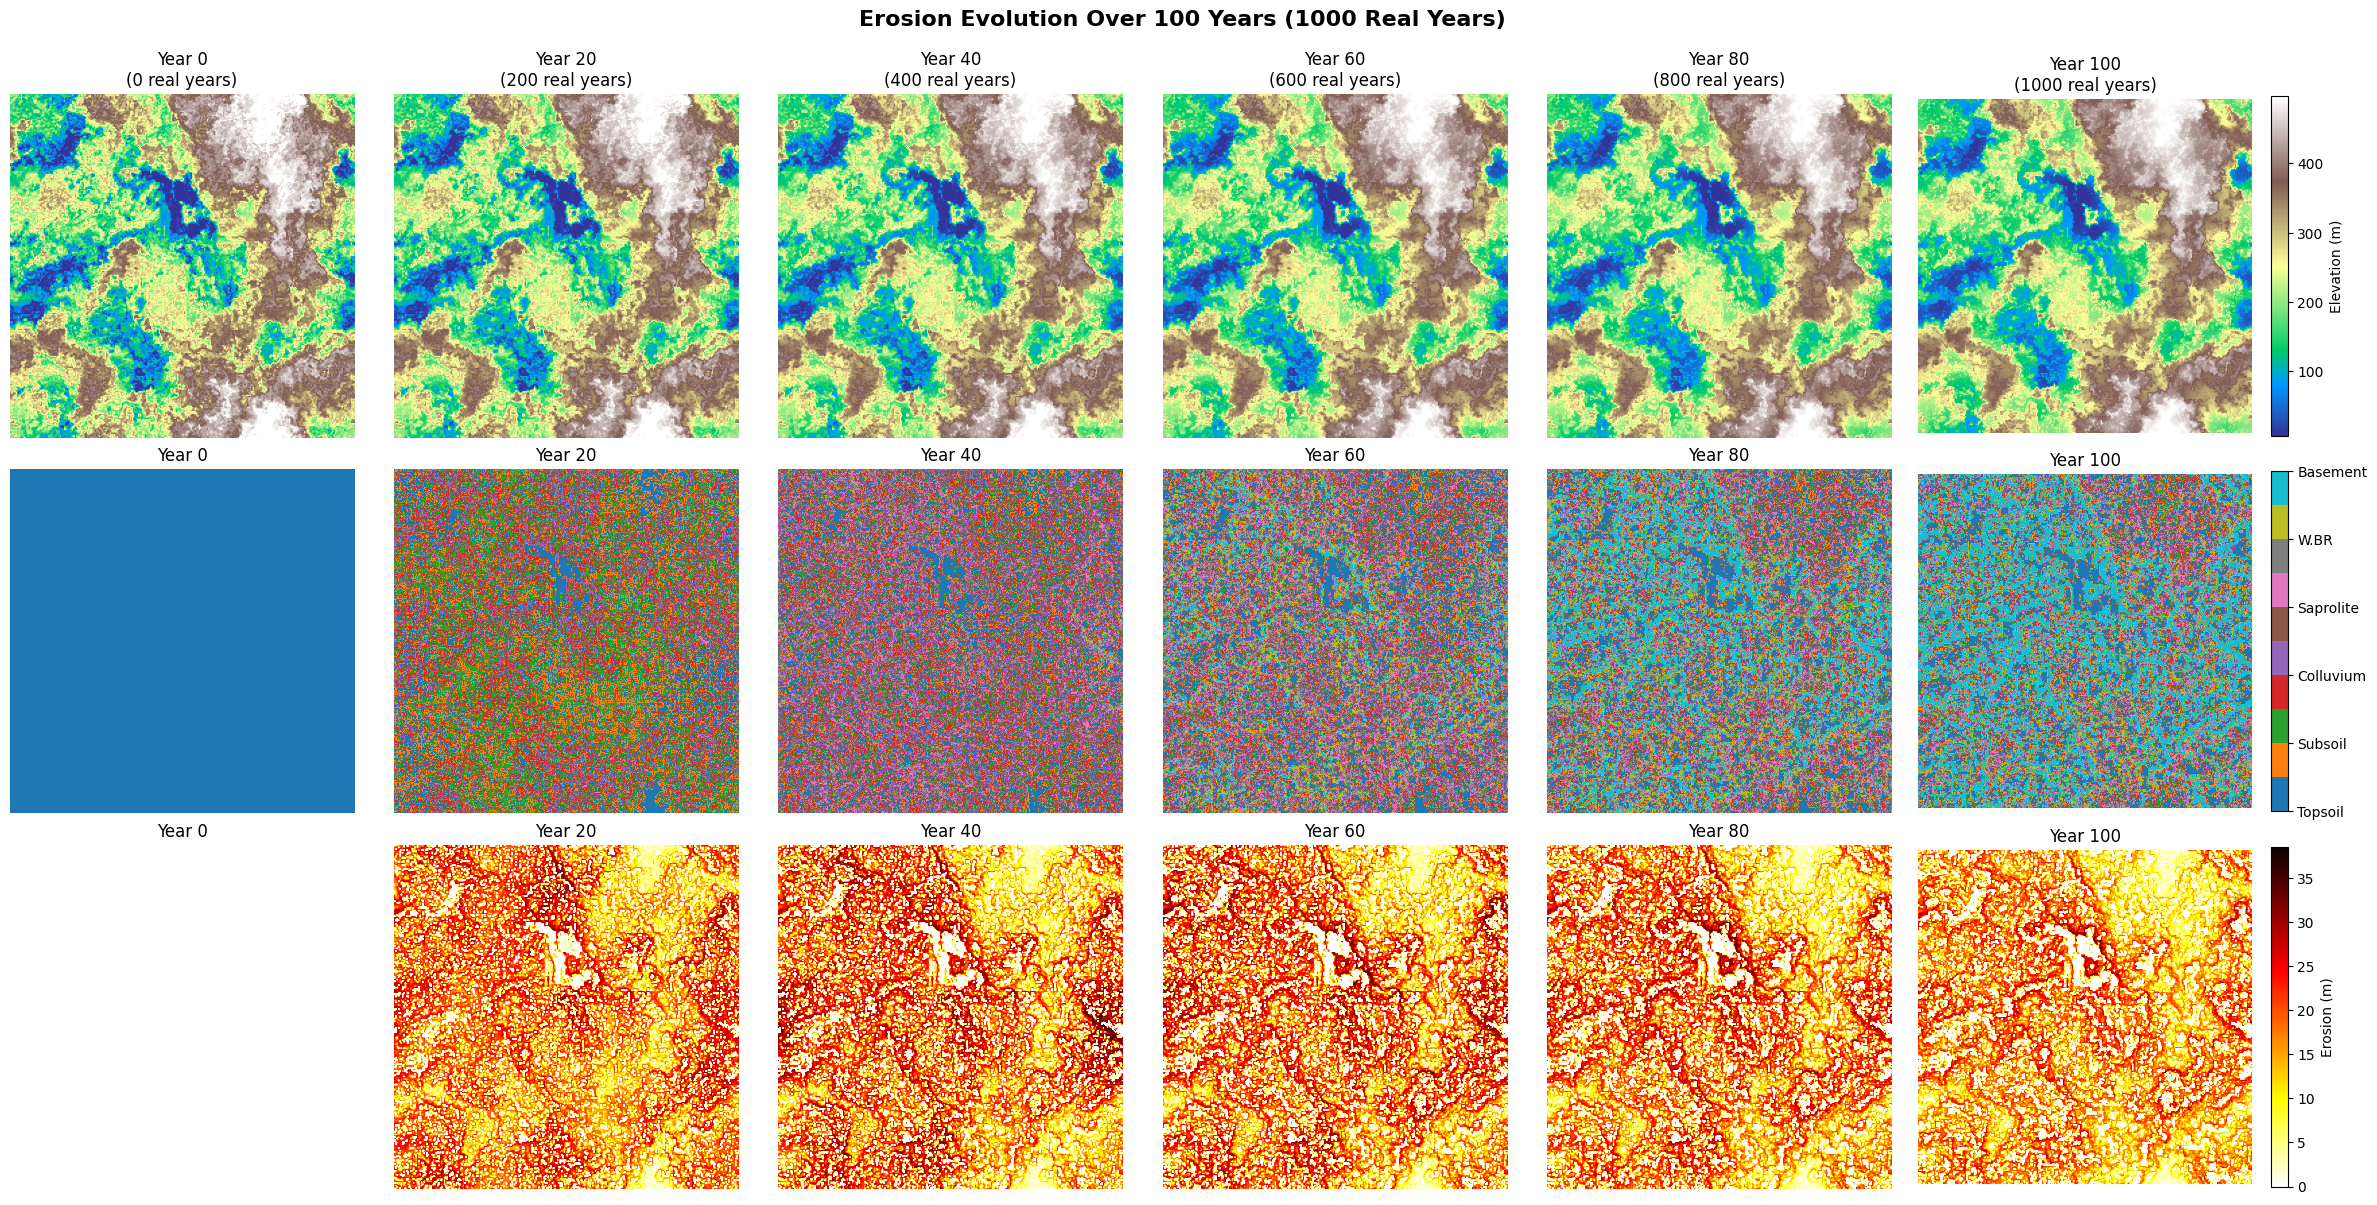

✓ Epoch plots generated

Generating final water snapshot visualization...


/var/folders/w2/tldkxgz91wv5m9cdyx8l4gp80000gp/T/ipykernel_5014/928589354.py:397: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from current font.
  plt.tight_layout()
/Users/alextrujillo/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


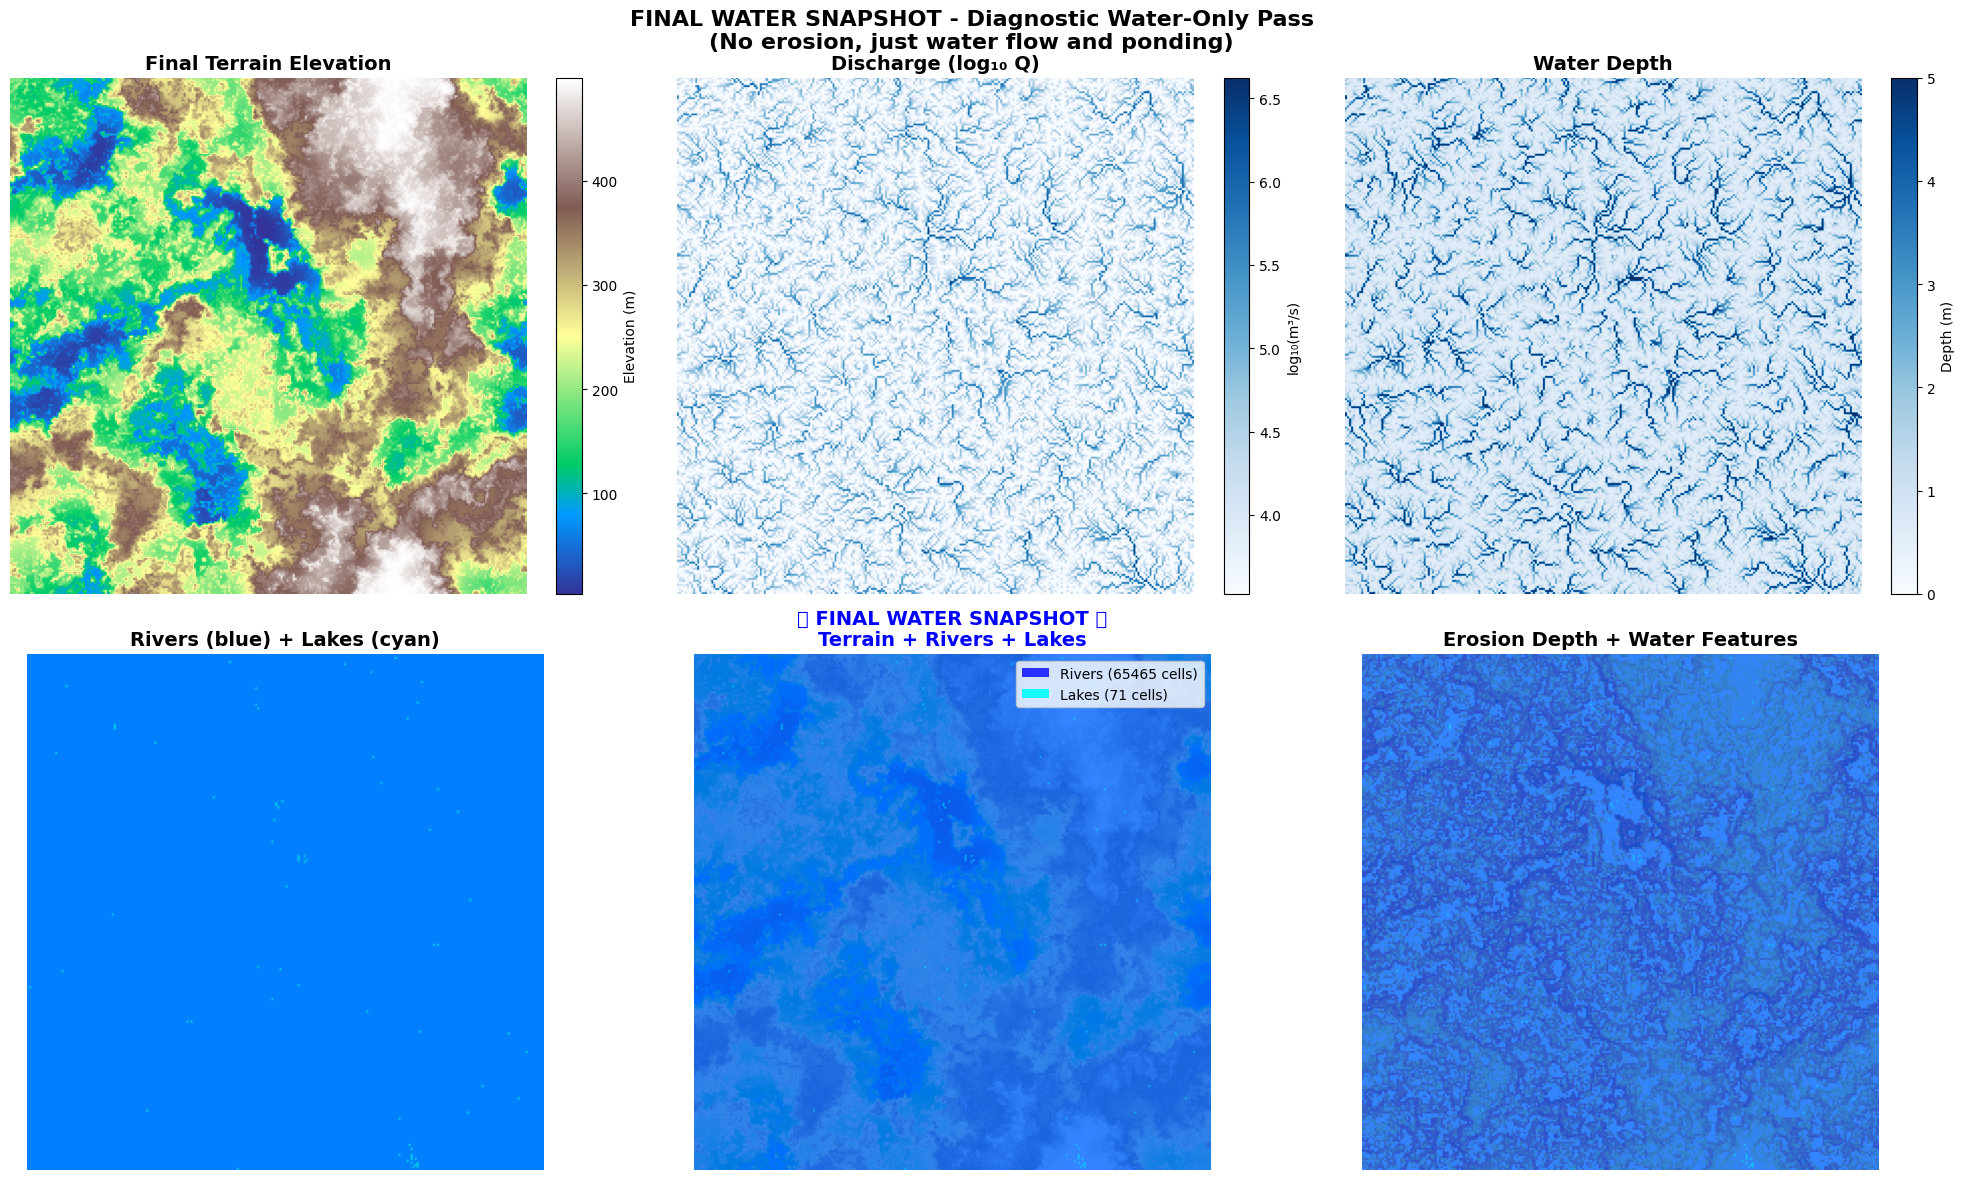

✓ Water snapshot visualization complete

Generating cross-section with water table...


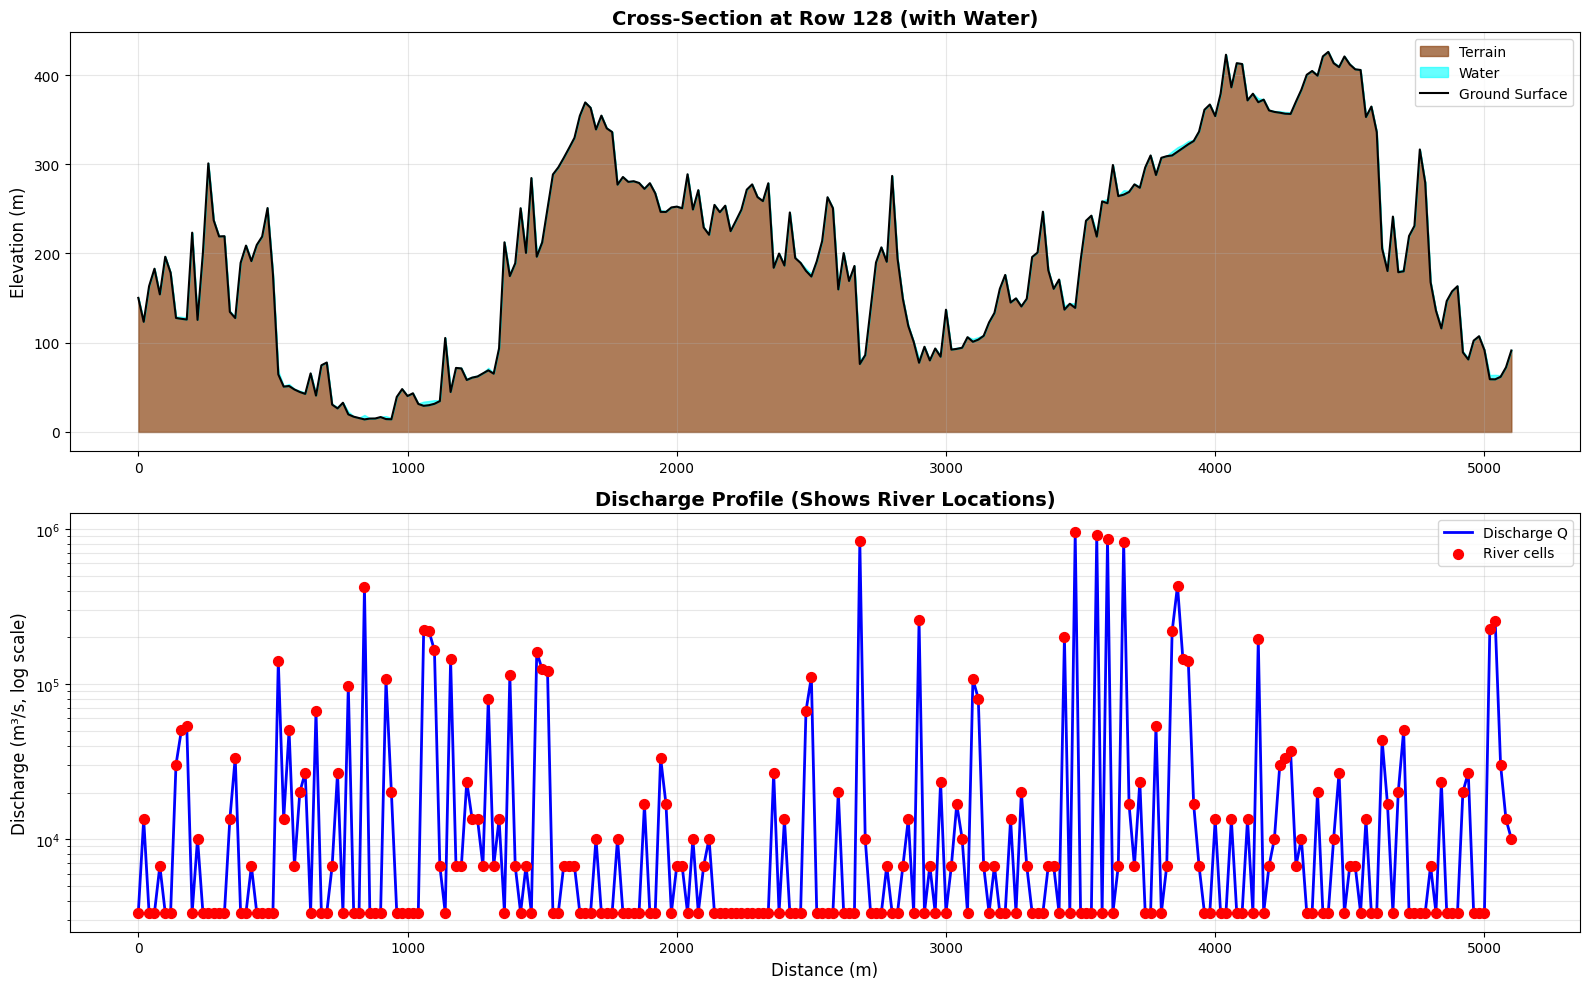

✓ Cross-section with water generated

SUMMARY

Simulation:
  Duration: 100 sim years = 1000 real years
  Epochs: 5

Erosion:
  Mean: 8.02 m
  Max: 38.53 m
  Std dev: 18.74 m

Water Features (Final Snapshot):
  Snapshot rain: 12.00 m
  Max discharge: 4.20e+06 m³/s
  River cells: 65465 (99.89%)
  Lake cells: 71 (0.11%)
  Max water depth: 5.00 m

✅ COMPLETE: EROSION + EPOCH ANALYSIS + WATER SNAPSHOT

Key visualizations generated:
  1. Epoch-by-epoch evolution (elevation, materials, erosion)
  2. Final water snapshot (terrain + rivers + lakes overlay)
  3. Cross-section with water table

✓ Water snapshot shows:
  • Rivers (blue lines) - high discharge, sloped channels
  • Lakes (cyan areas) - water ponding in flat basins
  • Final terrain with realistic drainage network



In [28]:
"""
EROSION DEMONSTRATION WITH EPOCH VISUALIZATION + FINAL WATER SNAPSHOT

Features:
- Uses realistic layers from cells 0-9
- Non-uniform rain from wind physics
- Shows erosion progress after each epoch
- FINAL WATER SNAPSHOT: Shows rivers and lakes on final terrain
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import time

print("\n" + "="*80)
print("EROSION SIMULATION WITH EPOCH VISUALIZATION + WATER SNAPSHOT")
print("="*80)

# ==============================================================================
# VALIDATE INPUT DATA
# ==============================================================================

print("\nValidating input data...")

# Check for global variables
if 'GLOBAL_STRATA' not in globals():
    raise RuntimeError("GLOBAL_STRATA not found! Run cells 0-9 first.")
if 'GLOBAL_WEATHER_DATA' not in globals():
    raise RuntimeError("GLOBAL_WEATHER_DATA not found! Run cells 0-9 first.")
if 'GLOBAL_RAIN_TIMESERIES' not in globals():
    raise RuntimeError("GLOBAL_RAIN_TIMESERIES not found! Run cells 0-9 first.")

print("✓ All global variables found")

# Extract data
elevation_initial = GLOBAL_STRATA['surface_elev'].copy()
thickness_initial = {k: v.copy() for k, v in GLOBAL_STRATA['thickness'].items()}
layer_order = GLOBAL_STRATA['layer_order'].copy()
pixel_scale_m = GLOBAL_STRATA['pixel_scale_m']
rain_timeseries = GLOBAL_RAIN_TIMESERIES.copy()

print(f"✓ Using terrain from cells 0-9: {elevation_initial.shape}")
print(f"✓ Using {len(layer_order)} layers: {layer_order}")
print(f"✓ Using {len(rain_timeseries)} years of rain data")

# ==============================================================================
# RUN EROSION WITH EPOCH SNAPSHOTS
# ==============================================================================

print("\n" + "="*80)
print("RUNNING EROSION SIMULATION")
print("="*80)

# Simulation parameters
num_epochs = 5  # Number of epochs to show
years_per_epoch = 20  # Years between snapshots
total_years = num_epochs * years_per_epoch

print(f"\nSimulation plan:")
print(f"  Total years: {total_years}")
print(f"  Epochs: {num_epochs}")
print(f"  Years per epoch: {years_per_epoch}")
print(f"  Real-world equivalent: {total_years * TIME_ACCELERATION:.0f} years")

# Storage for epoch snapshots
epoch_elevations = []
epoch_layers = []
epoch_years = []

# Current state
elevation = elevation_initial.copy()
thickness = {k: v.copy() for k, v in thickness_initial.items()}

# Initial snapshot
epoch_elevations.append(elevation.copy())
top_idx, top_name = compute_top_layer_map(thickness, layer_order)
epoch_layers.append(top_name.copy())
epoch_years.append(0)

print(f"\nEpoch 0: Initial state")
print(f"  Elevation: {elevation.min():.1f} - {elevation.max():.1f} m")

# Run simulation epoch by epoch
for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{num_epochs}: Years {(epoch-1)*years_per_epoch} → {epoch*years_per_epoch}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Run erosion for this epoch
    # NOTE: run_erosion_simulation uses global constants from Cell 10
    results = run_erosion_simulation(
        elevation_initial=elevation,
        thickness_initial=thickness,
        layer_order=layer_order,
        rain_timeseries=rain_timeseries[(epoch-1)*years_per_epoch:epoch*years_per_epoch],
        pixel_scale_m=pixel_scale_m,
        dt=1.0,
        num_timesteps=years_per_epoch,
        save_interval=years_per_epoch,  # Save only at end
        apply_diffusion=True,
        verbose=True
    )
    
    elapsed = time.time() - start_time
    
    # Update state for next epoch
    elevation = results['elevation_final']
    thickness = results['thickness_final']
    
    # Save snapshot
    epoch_elevations.append(elevation.copy())
    top_idx, top_name = compute_top_layer_map(thickness, layer_order)
    epoch_layers.append(top_name.copy())
    epoch_years.append(epoch * years_per_epoch)
    
    # Stats
    elev_change = elevation - elevation_initial
    print(f"\n✓ Epoch {epoch} complete in {elapsed:.1f} s")
    print(f"  Elevation: {elevation.min():.1f} - {elevation.max():.1f} m")
    print(f"  Total erosion: {-elev_change.min():.1f} m (max)")
    print(f"  Mean change: {elev_change.mean():.2f} m")

print("\n" + "="*80)
print("✅ EROSION SIMULATION COMPLETE")
print("="*80)

# ==============================================================================
# FINAL WATER SNAPSHOT (Diagnostic Water-Only Pass)
# ==============================================================================

print("\n" + "="*80)
print("COMPUTING FINAL WATER SNAPSHOT (Rivers + Lakes)")
print("="*80)

print("\nFreezing terrain at final elevation...")
print("Applying diagnostic rain event (water-only, no erosion)...")

# Use final elevation
elevation_final = epoch_elevations[-1].copy()
ny, nx = elevation_final.shape

# Apply a strong uniform rain event for water visualization
SNAPSHOT_RAIN_INTENSITY = 0.01  # m/hour
SNAPSHOT_RAIN_DURATION = 24  # hours
SNAPSHOT_RAIN_BOOST = 50.0  # Boost factor to fill channels

rain_snapshot = np.ones((ny, nx), dtype=np.float32) * SNAPSHOT_RAIN_INTENSITY * SNAPSHOT_RAIN_DURATION * SNAPSHOT_RAIN_BOOST

print(f"  Rain intensity: {SNAPSHOT_RAIN_INTENSITY * SNAPSHOT_RAIN_DURATION * SNAPSHOT_RAIN_BOOST:.2f} m")

# Compute runoff (simple)
infiltration_frac = INFILTRATION_FRACTION
runoff_snapshot = rain_snapshot * (1 - infiltration_frac)

# Compute flow direction from final elevation
flow_dir_snapshot, receivers_snapshot, distances_snapshot = compute_flow_direction_d8(elevation_final, pixel_scale_m)

# Compute discharge Q (water accumulation)
discharge_snapshot = compute_discharge(elevation_final, flow_dir_snapshot, receivers_snapshot, runoff_snapshot, pixel_scale_m)

print(f"✓ Flow and discharge computed")
print(f"  Max discharge: {discharge_snapshot.max():.2e} m³/s")
print(f"  Mean discharge: {discharge_snapshot.mean():.2e} m³/s")

# Convert discharge to water depth (simple model)
WATER_DEPTH_K = 0.01  # Tunable coefficient
MAX_WATER_DEPTH = 5.0  # Maximum water depth (m)

water_depth = WATER_DEPTH_K * np.sqrt(discharge_snapshot)  # sqrt to avoid extreme values
water_depth = np.clip(water_depth, 0, MAX_WATER_DEPTH)

print(f"✓ Water depth computed")
print(f"  Max depth: {water_depth.max():.2f} m")
print(f"  Mean depth: {water_depth.mean():.3f} m")

# Detect rivers and lakes
WATER_MIN_DEPTH = 0.05  # Minimum depth to consider (m)
SLOPE_LAKE_THRESHOLD = 0.01  # Slope threshold for lake vs river

# Compute slopes along flow direction
grad_y, grad_x = np.gradient(elevation_final, pixel_scale_m)
slope_mag = np.sqrt(grad_x**2 + grad_y**2)

# Classify water features
river_mask = (water_depth > WATER_MIN_DEPTH) & (slope_mag > SLOPE_LAKE_THRESHOLD)
lake_mask = (water_depth > WATER_MIN_DEPTH) & (slope_mag <= SLOPE_LAKE_THRESHOLD)

num_river_cells = np.sum(river_mask)
num_lake_cells = np.sum(lake_mask)

print(f"\n✓ Water features detected:")
print(f"  River cells: {num_river_cells} ({100*num_river_cells/(ny*nx):.2f}%)")
print(f"  Lake cells: {num_lake_cells} ({100*num_lake_cells/(ny*nx):.2f}%)")

# Also use the existing river/lake detection from cell 16
try:
    river_mask_advanced = detect_rivers(discharge_snapshot, pixel_scale_m, 
                                        discharge_threshold=np.percentile(discharge_snapshot, 95))
    lake_mask_advanced, lake_labels = detect_lakes(elevation_final, discharge_snapshot, 
                                                     pixel_scale_m, min_lake_area_m2=100)
    
    num_lakes = len(np.unique(lake_labels)) - 1  # Exclude 0 (no lake)
    print(f"\n✓ Advanced detection:")
    print(f"  River cells (advanced): {np.sum(river_mask_advanced)} ({100*np.sum(river_mask_advanced)/(ny*nx):.2f}%)")
    print(f"  Number of lakes: {num_lakes}")
    print(f"  Lake cells (advanced): {np.sum(lake_mask_advanced)} ({100*np.sum(lake_mask_advanced)/(ny*nx):.2f}%)")
    
    # Use advanced masks
    river_mask = river_mask_advanced
    lake_mask = lake_mask_advanced
except:
    print("\n⚠ Advanced detection failed, using simple classification")

print("\n" + "="*80)
print("✅ WATER SNAPSHOT COMPLETE")
print("="*80)

# ==============================================================================
# EPOCH-BY-EPOCH VISUALIZATION
# ==============================================================================

print("\nGenerating epoch-by-epoch plots...")

fig, axes = plt.subplots(3, num_epochs + 1, figsize=(4*(num_epochs+1), 12))

# Compute elevation range for consistent colorscale
all_elevs = np.concatenate([e.flatten() for e in epoch_elevations])
vmin, vmax = np.percentile(all_elevs, [1, 99])

# Compute total change
initial_elev = epoch_elevations[0]
max_erosion = 0

# Row 1: Elevation maps
for i, (elev, year) in enumerate(zip(epoch_elevations, epoch_years)):
    ax = axes[0, i]
    im = ax.imshow(elev, cmap='terrain', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(f"Year {year}\n({year * TIME_ACCELERATION:.0f} real years)")
    ax.axis('off')
    if i == num_epochs:
        plt.colorbar(im, ax=ax, label='Elevation (m)', fraction=0.046)

axes[0, 0].set_ylabel("ELEVATION", fontsize=12, fontweight='bold')

# Row 2: Surface material
layer_colors_map = {
    'Topsoil': 0, 'Subsoil': 1, 'Colluvium': 2,
    'Saprolite': 3, 'WeatheredBR': 4, 'Basement': 5
}

for i, (layer_map, year) in enumerate(zip(epoch_layers, epoch_years)):
    ax = axes[1, i]
    
    # Convert layer names to colors
    ny_plot, nx_plot = layer_map.shape
    color_map = np.zeros((ny_plot, nx_plot))
    for ii in range(ny_plot):
        for jj in range(nx_plot):
            color_map[ii, jj] = layer_colors_map.get(layer_map[ii, jj], 5)
    
    im = ax.imshow(color_map, cmap='tab10', vmin=0, vmax=5, origin='lower')
    ax.set_title(f"Year {year}")
    ax.axis('off')
    
    if i == num_epochs:
        cbar = plt.colorbar(im, ax=ax, ticks=[0,1,2,3,4,5], fraction=0.046)
        cbar.set_ticklabels(['Topsoil', 'Subsoil', 'Colluvium', 'Saprolite', 'W.BR', 'Basement'])

axes[1, 0].set_ylabel("SURFACE MATERIAL", fontsize=12, fontweight='bold')

# Row 3: Erosion depth (cumulative)
for i, (elev, year) in enumerate(zip(epoch_elevations, epoch_years)):
    ax = axes[2, i]
    
    erosion_depth = initial_elev - elev  # Positive = erosion
    max_erosion = max(max_erosion, erosion_depth.max())
    
    im = ax.imshow(erosion_depth, cmap='hot_r', vmin=0, vmax=None, origin='lower')
    ax.set_title(f"Year {year}")
    ax.axis('off')
    
    if i == num_epochs:
        plt.colorbar(im, ax=ax, label='Erosion (m)', fraction=0.046)

axes[2, 0].set_ylabel("EROSION DEPTH", fontsize=12, fontweight='bold')

plt.suptitle(f"Erosion Evolution Over {total_years} Years ({total_years * TIME_ACCELERATION:.0f} Real Years)", 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Epoch plots generated")

# ==============================================================================
# FINAL WATER SNAPSHOT VISUALIZATION (Rivers + Lakes Overlay)
# ==============================================================================

print("\nGenerating final water snapshot visualization...")

fig = plt.figure(figsize=(20, 12))

# Create 2x3 grid
ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)
ax4 = plt.subplot(2, 3, 4)
ax5 = plt.subplot(2, 3, 5)
ax6 = plt.subplot(2, 3, 6)

# Plot 1: Final elevation (terrain)
im1 = ax1.imshow(elevation_final, cmap='terrain', origin='lower')
ax1.set_title("Final Terrain Elevation", fontsize=14, fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, label='Elevation (m)', fraction=0.046)

# Plot 2: Discharge (Q) - shows water flux
im2 = ax2.imshow(np.log10(discharge_snapshot + 1e-6), cmap='Blues', origin='lower')
ax2.set_title("Discharge (log₁₀ Q)", fontsize=14, fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, label='log₁₀(m³/s)', fraction=0.046)

# Plot 3: Water depth
im3 = ax3.imshow(water_depth, cmap='Blues', vmin=0, vmax=water_depth.max(), origin='lower')
ax3.set_title("Water Depth", fontsize=14, fontweight='bold')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, label='Depth (m)', fraction=0.046)

# Plot 4: Rivers and Lakes (Binary masks)
water_vis = np.zeros((ny, nx, 3))
water_vis[:, :, 0] = 0.8  # Red channel (terrain base)
water_vis[:, :, 1] = 0.7  # Green channel
water_vis[:, :, 2] = 0.6  # Blue channel

# Rivers = blue lines
water_vis[river_mask, 0] = 0.0
water_vis[river_mask, 1] = 0.5
water_vis[river_mask, 2] = 1.0

# Lakes = cyan filled
water_vis[lake_mask, 0] = 0.0
water_vis[lake_mask, 1] = 0.8
water_vis[lake_mask, 2] = 0.9

ax4.imshow(water_vis, origin='lower')
ax4.set_title("Rivers (blue) + Lakes (cyan)", fontsize=14, fontweight='bold')
ax4.axis('off')

# Plot 5: **MAIN VISUALIZATION** - Terrain with rivers/lakes overlay
# This is the "screenshot" requested
terrain_rgb = plt.cm.terrain((elevation_final - elevation_final.min()) / (elevation_final.max() - elevation_final.min() + 1e-9))[:, :, :3]

# Create water overlay
water_overlay = np.zeros((ny, nx, 4))  # RGBA
water_overlay[:, :, 3] = 0.0  # Transparent by default

# Rivers: bright blue, semi-transparent
water_overlay[river_mask, 0] = 0.0  # R
water_overlay[river_mask, 1] = 0.4  # G
water_overlay[river_mask, 2] = 1.0  # B (bright blue)
water_overlay[river_mask, 3] = 0.8  # Alpha (semi-transparent)

# Lakes: cyan, more opaque
water_overlay[lake_mask, 0] = 0.0  # R
water_overlay[lake_mask, 1] = 0.7  # G
water_overlay[lake_mask, 2] = 1.0  # B
water_overlay[lake_mask, 3] = 0.9  # Alpha (more opaque)

# Composite
ax5.imshow(terrain_rgb, origin='lower')
ax5.imshow(water_overlay, origin='lower')
ax5.set_title("🌊 FINAL WATER SNAPSHOT 🌊\nTerrain + Rivers + Lakes", 
              fontsize=14, fontweight='bold', color='blue')
ax5.axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.8, label=f'Rivers ({num_river_cells} cells)'),
    Patch(facecolor='cyan', alpha=0.9, label=f'Lakes ({num_lake_cells} cells)')
]
ax5.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Plot 6: Erosion depth with water overlay
erosion_final = initial_elev - elevation_final
erosion_rgb = plt.cm.hot_r(erosion_final / (erosion_final.max() + 1e-9))[:, :, :3]

ax6.imshow(erosion_rgb, origin='lower')
ax6.imshow(water_overlay, origin='lower')
ax6.set_title("Erosion Depth + Water Features", fontsize=14, fontweight='bold')
ax6.axis('off')

plt.suptitle("FINAL WATER SNAPSHOT - Diagnostic Water-Only Pass\n(No erosion, just water flow and ponding)", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Water snapshot visualization complete")

# ==============================================================================
# CROSS-SECTION WITH WATER
# ==============================================================================

print("\nGenerating cross-section with water table...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Cross-section at middle row
mid_row = ny // 2
x_coords = np.arange(nx) * pixel_scale_m

# Plot 1: Elevation profile with water
ax1.fill_between(x_coords, 0, elevation_final[mid_row, :], color='saddlebrown', alpha=0.7, label='Terrain')
water_surface = elevation_final[mid_row, :] + water_depth[mid_row, :]
ax1.fill_between(x_coords, elevation_final[mid_row, :], water_surface, 
                 where=(water_depth[mid_row, :] > WATER_MIN_DEPTH),
                 color='cyan', alpha=0.6, label='Water')
ax1.plot(x_coords, elevation_final[mid_row, :], 'k-', linewidth=1.5, label='Ground Surface')
ax1.set_ylabel("Elevation (m)", fontsize=12)
ax1.set_title(f"Cross-Section at Row {mid_row} (with Water)", fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Discharge profile
ax2.semilogy(x_coords, discharge_snapshot[mid_row, :], 'b-', linewidth=2, label='Discharge Q')
ax2.set_xlabel("Distance (m)", fontsize=12)
ax2.set_ylabel("Discharge (m³/s, log scale)", fontsize=12)
ax2.set_title("Discharge Profile (Shows River Locations)", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend()

# Highlight river locations
river_locs = np.where(river_mask[mid_row, :])[0]
if len(river_locs) > 0:
    ax2.scatter(river_locs * pixel_scale_m, discharge_snapshot[mid_row, river_locs],
                color='red', s=50, zorder=10, label='River cells')
    ax2.legend()

plt.tight_layout()
plt.show()

print("✓ Cross-section with water generated")

# ==============================================================================
# SUMMARY
# ==============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print(f"\nSimulation:")
print(f"  Duration: {total_years} sim years = {total_years * TIME_ACCELERATION:.0f} real years")
print(f"  Epochs: {num_epochs}")

print(f"\nErosion:")
final_erosion = initial_elev - epoch_elevations[-1]
print(f"  Mean: {final_erosion.mean():.2f} m")
print(f"  Max: {final_erosion.max():.2f} m")
print(f"  Std dev: {final_erosion.std():.2f} m")

print(f"\nWater Features (Final Snapshot):")
print(f"  Snapshot rain: {SNAPSHOT_RAIN_INTENSITY * SNAPSHOT_RAIN_DURATION * SNAPSHOT_RAIN_BOOST:.2f} m")
print(f"  Max discharge: {discharge_snapshot.max():.2e} m³/s")
print(f"  River cells: {num_river_cells} ({100*num_river_cells/(ny*nx):.2f}%)")
print(f"  Lake cells: {num_lake_cells} ({100*num_lake_cells/(ny*nx):.2f}%)")
print(f"  Max water depth: {water_depth.max():.2f} m")

print("\n" + "="*80)
print("✅ COMPLETE: EROSION + EPOCH ANALYSIS + WATER SNAPSHOT")
print("="*80)
print("\nKey visualizations generated:")
print("  1. Epoch-by-epoch evolution (elevation, materials, erosion)")
print("  2. Final water snapshot (terrain + rivers + lakes overlay)")
print("  3. Cross-section with water table")
print("\n✓ Water snapshot shows:")
print("  • Rivers (blue lines) - high discharge, sloped channels")
print("  • Lakes (cyan areas) - water ponding in flat basins")
print("  • Final terrain with realistic drainage network")
print("="*80 + "\n")
